<a href="https://colab.research.google.com/github/santoshlinkha/NEPSE_scraper/blob/main/temp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import scipy.stats as ss
from scipy.stats import norm

import matplotlib.pyplot as plt

In [ ]:
# Plot the time series
def time_series_plot(data, ticker):
    plt.subplot(4, 1, 1)
    plt.plot(data)
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.title("Prices")
    plt.legend(ticker, loc='upper left', bbox_to_anchor=(1,1))
    fig = plt.gcf()
    fig.set_size_inches(16, 16)
    plt.show()

    daily_returns = data.pct_change()

    plt.subplot(4, 1, 2)
    plt.plot(daily_returns)
    plt.xlabel("Date")
    plt.ylabel("Percentage")
    plt.title("Dailty Returns")
    plt.legend(ticker, loc='upper left', bbox_to_anchor=(1,1))
    fig = plt.gcf()
    fig.set_size_inches(16, 16)
    plt.show()

    plt.subplot(4, 1, 3)
    plt.plot(daily_returns.mean(axis=1))
    plt.xlabel("Date")
    plt.ylabel("Percentage")
    plt.title("Dailty Avg Returns")
    fig = plt.gcf()
    fig.set_size_inches(16, 20)
    plt.show()

    plt.subplot(4, 1, 3)
    ydata = daily_returns.std(axis=1)
    plt.plot(ydata)
    plt.xlabel("Date")
    plt.ylabel("Dispersion")
    plt.title("Dailty Price Dispersion")
    fig = plt.gcf()
    fig.set_size_inches(16, 20)
    plt.show()


# **Step 1**
Download financial time series from three different classes. First data is from equities, second is from crypto exchange, third is future.

[*********************100%%**********************]  10 of 10 completed


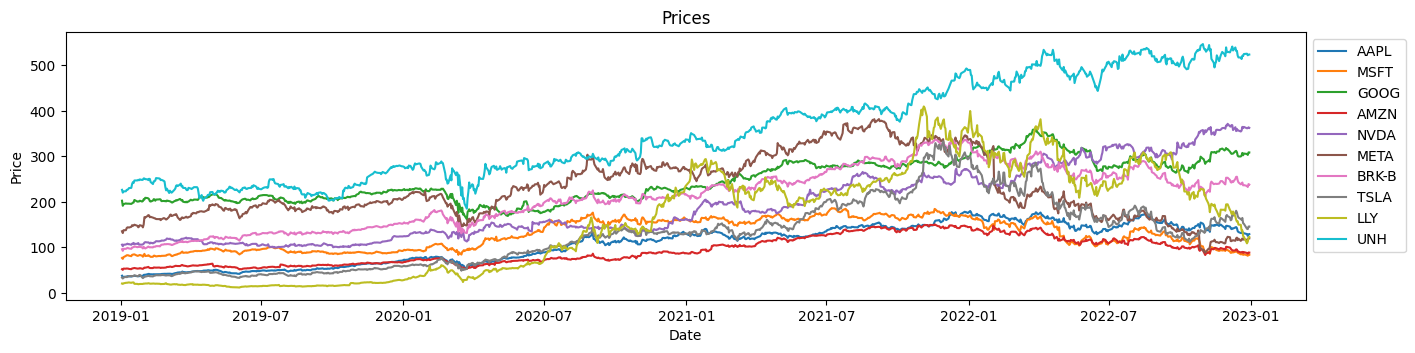

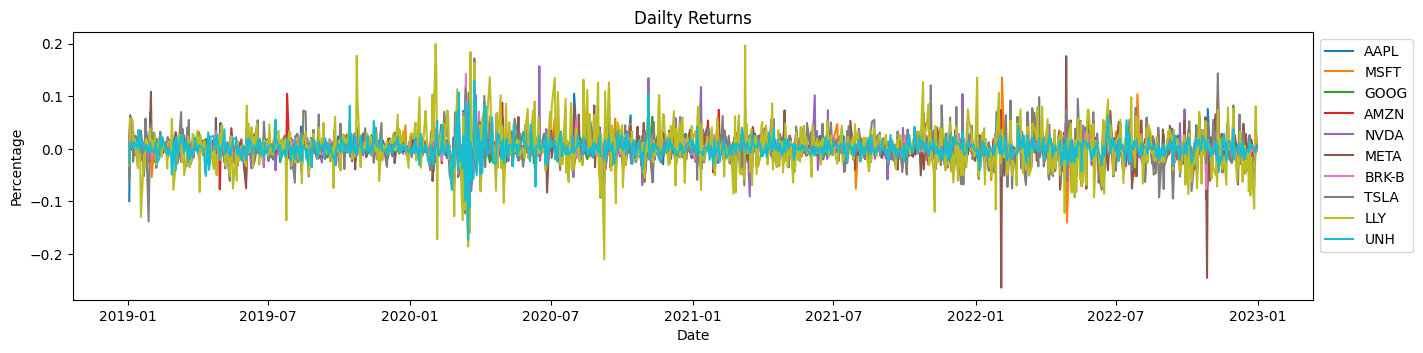

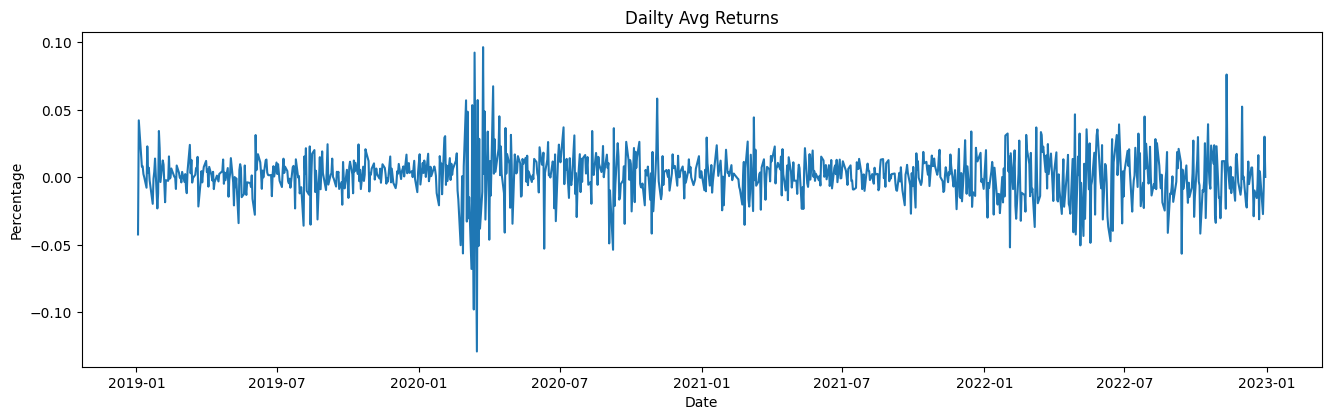

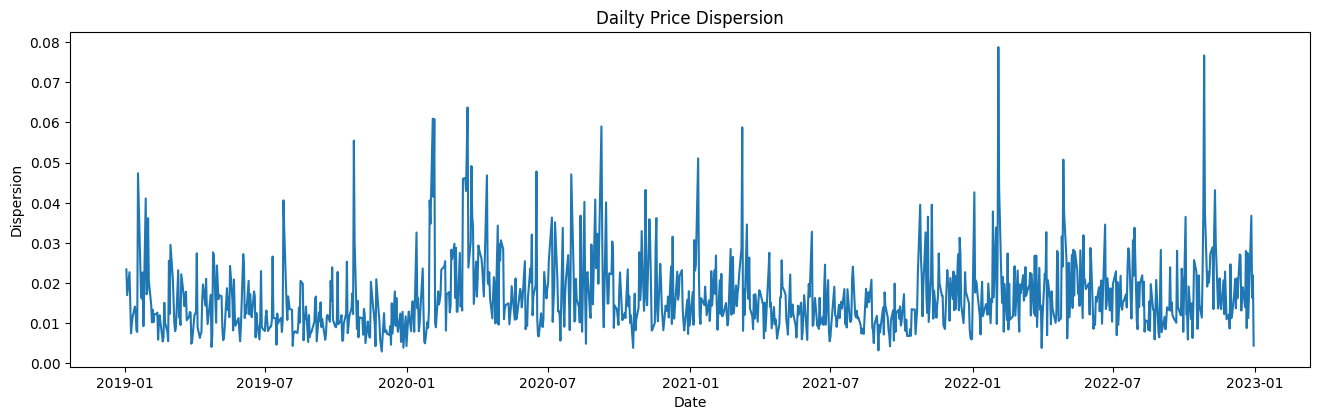

In [ ]:
# Data series 1
# Largest Companies by Market Capitalization

stocks = ["AAPL", "MSFT", "GOOG", "AMZN", "NVDA",
           "META", "BRK-B", "TSLA", "LLY", "UNH"]

# Define the start and end dates for the data you want
start_date = "2019-01-01"
end_date = "2022-12-31"

# Fetch VIX data for the specified date range
data = yf.download(stocks, start=start_date, end=end_date)["Adj Close"]
time_series_plot(data, stocks)


[*********************100%%**********************]  10 of 10 completed


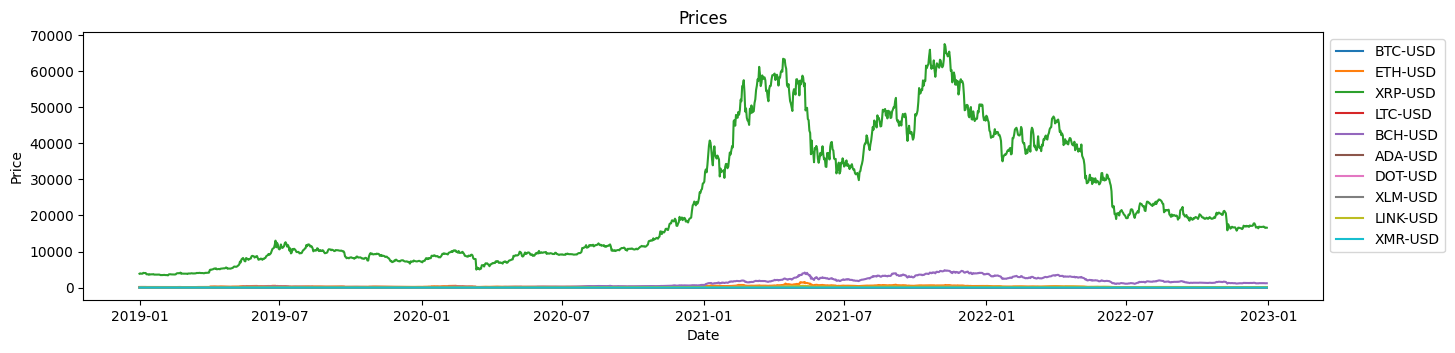

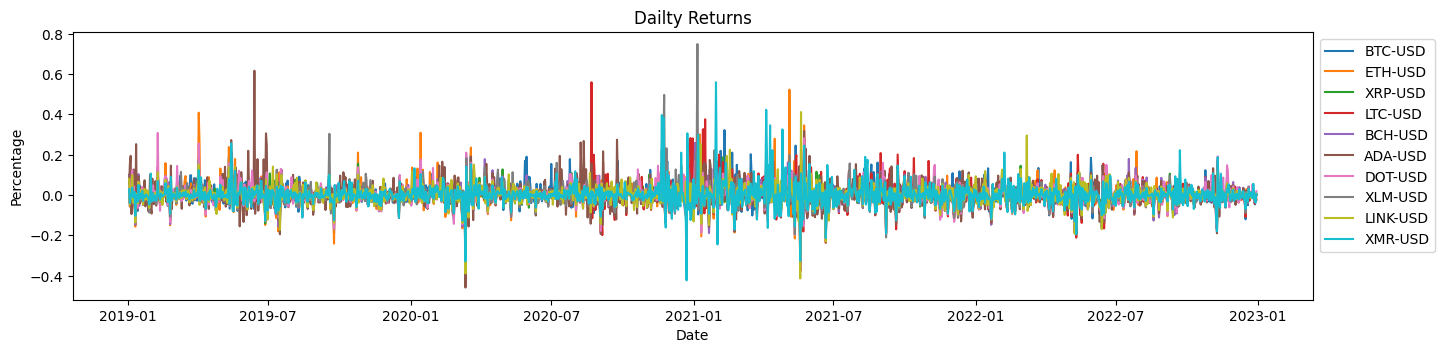

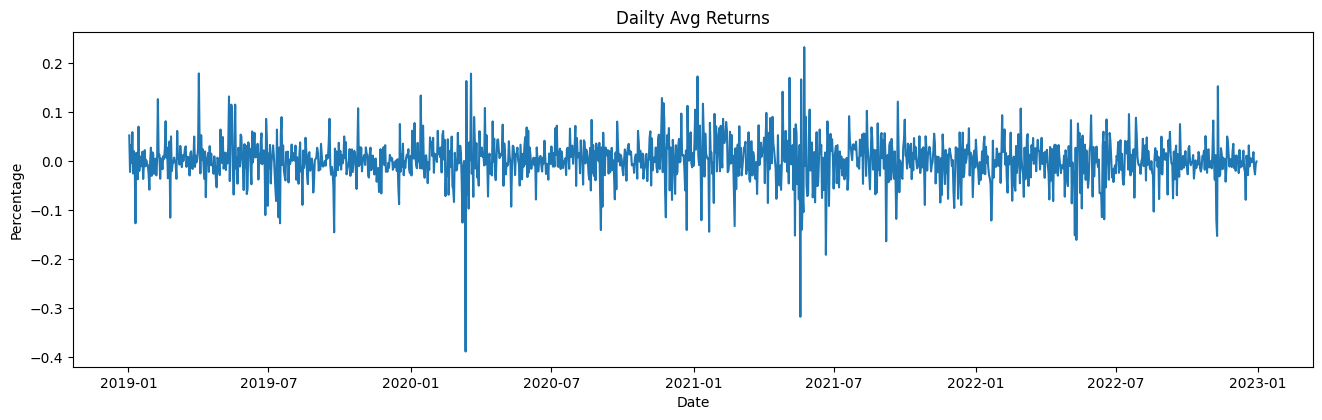

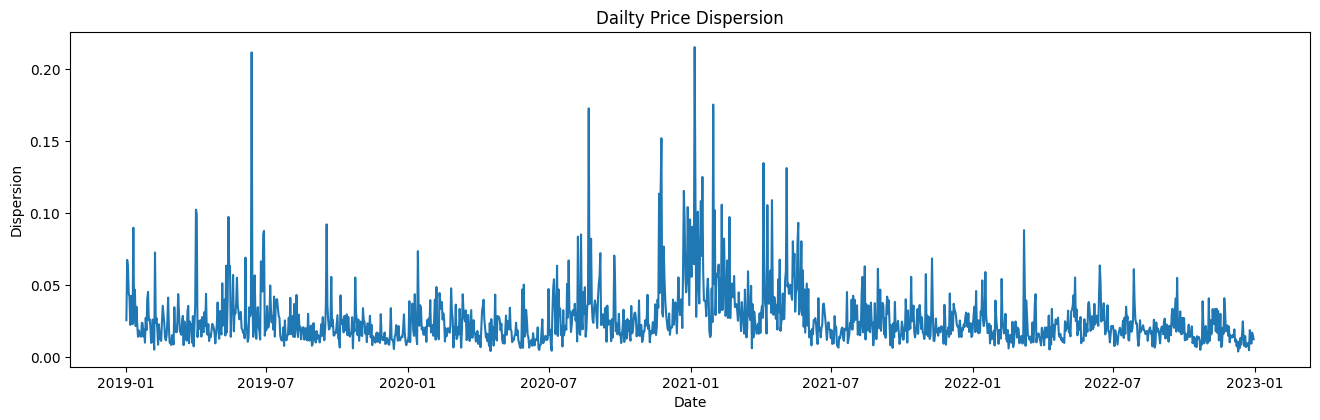

In [ ]:
# Data series 2
# Largest CRYPTO  by Market Capitalization

cryptos = ["BTC-USD", "ETH-USD", "XRP-USD", "LTC-USD", "BCH-USD",
           "ADA-USD", "DOT-USD", "XLM-USD", "LINK-USD", "XMR-USD"]

# Define the start and end dates for the data you want
start_date = "2019-01-01"
end_date = "2022-12-31"

# Fetch VIX data for the specified date range
data = yf.download(cryptos, start=start_date, end=end_date)["Adj Close"]
time_series_plot(data, cryptos)


[*********************100%%**********************]  10 of 10 completed


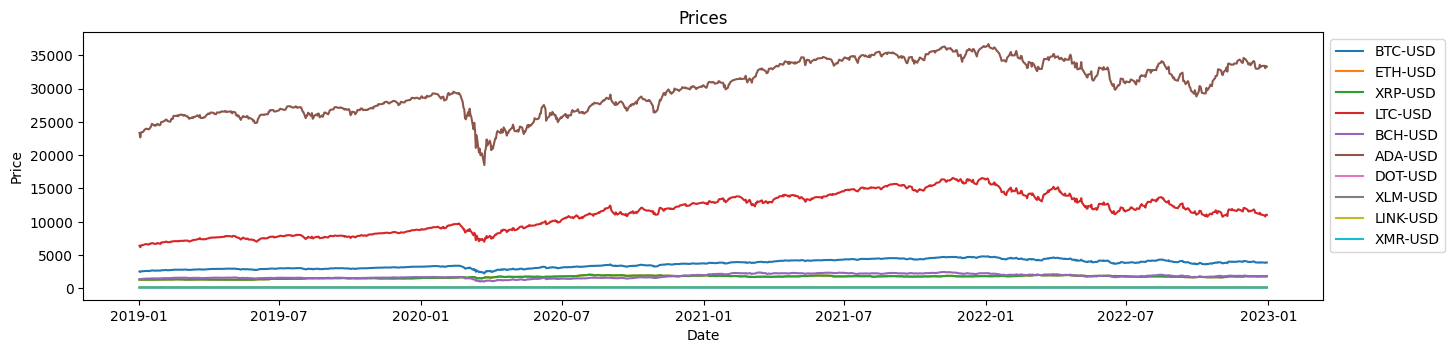

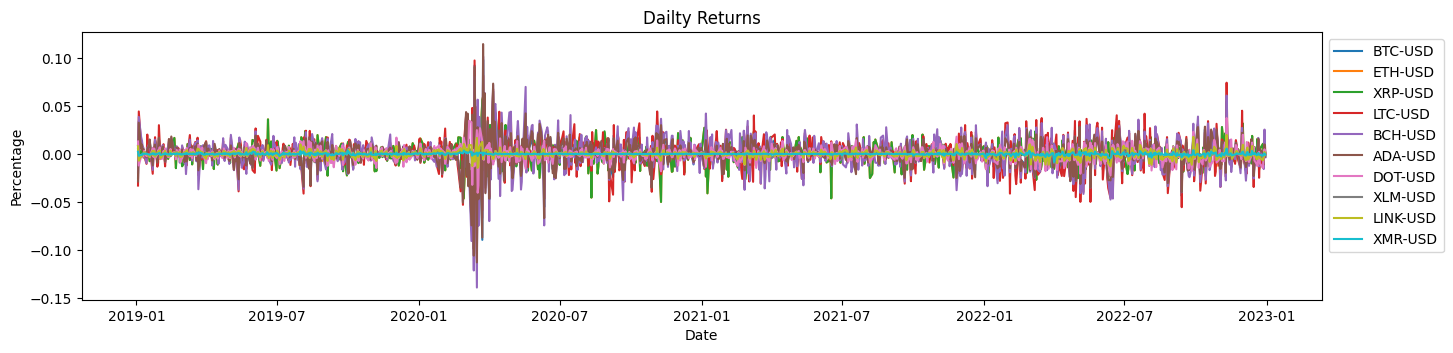

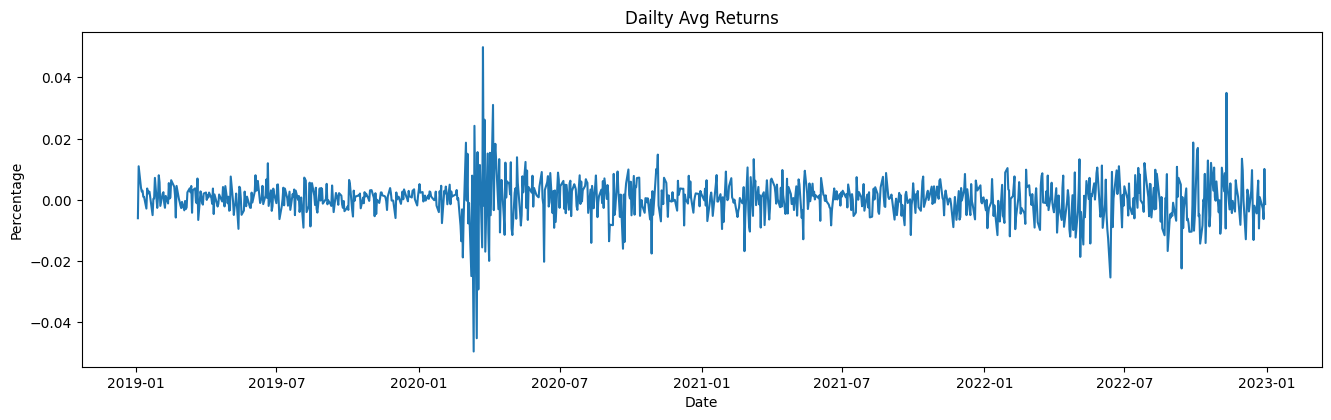

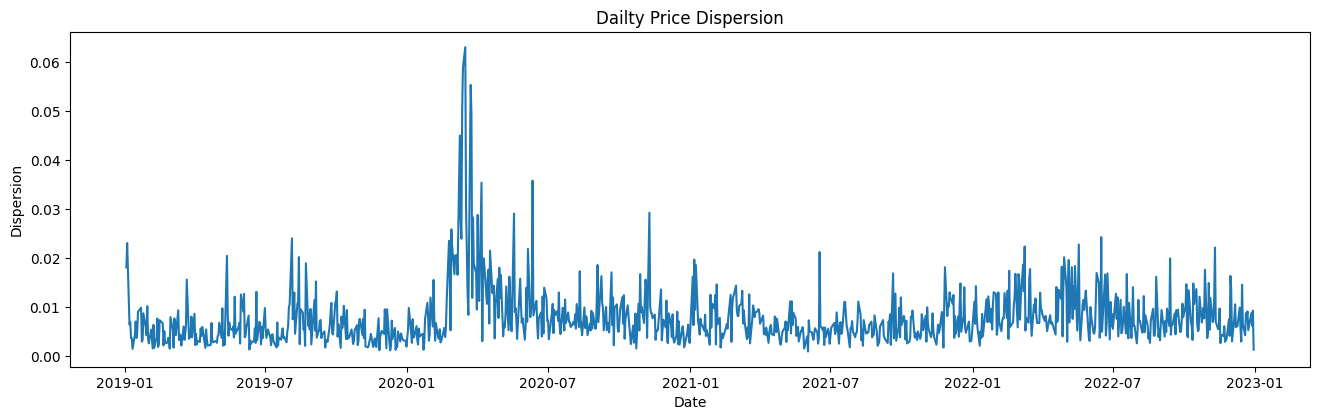

In [ ]:
# Data series 2
# Largest Futures by Volume

futures = ["ES=F", "YM=F", "NQ=F", "RTY=F", "ZB=F",
            "ZN=F", "ZF=F", "ZT=F", "GC=F", "MGC=F"]

# Define the start and end dates for the data you want
start_date = "2019-01-01"
end_date = "2022-12-31"

# Fetch VIX data for the specified date range
data = yf.download(futures, start=start_date, end=end_date)["Adj Close"]

time_series_plot(data, cryptos)

We will be using the dispersion of dailty return, which is the standard deviation of dailty returns of the same asset class. During the time of covid pandemic, all asset classes shows regime changes however futures market shows distinct regime changes.

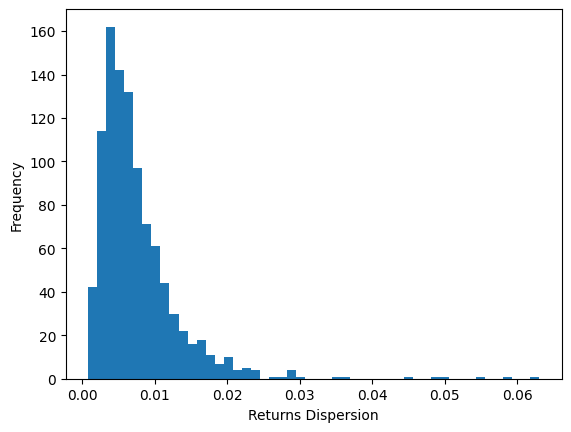

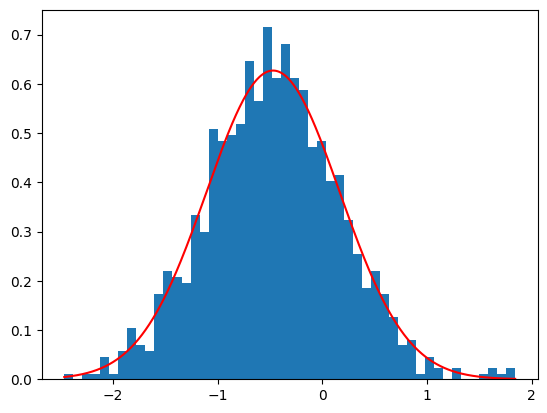

In [ ]:
ydata = data.pct_change().std(axis=1)

plt.figure(1)
plt.hist(ydata, bins = 50)
plt.xlabel("Returns Dispersion")
plt.ylabel("Frequency")
plt.show()

plt.figure(2)
YData = np.log(100*ydata.dropna().to_numpy())

xs = np.linspace(YData.min(), YData.max(), 500)


plt.hist(YData, density=True, bins = 50)
plt.plot(
    xs,
    ss.norm.pdf(xs, YData.mean(), YData.std()),
    color="r",
    label="Normal density"
)

plt.show()


In [ ]:
# Estimation of model with changes in volatility regimes
# Build function that performs the E step
# Likelihood of an observation


def likelihood(xi_prob, mu, sigma, y):
    phi = norm.pdf((y - mu) / sigma)/ sigma
    y_like = np.dot(xi_prob, phi)

    return y_like, phi


# Hamilton filtering
def forward_alg(pi0, N, T, P, mu, sigma, Y):
    xi_prob_t = np.zeros((T, N))
    xi_prob_t1 = np.zeros((T, N))

    # Case t=1
    #Likelihood of observation y_1 and marginal densities phi_1
    y_like, phi = likelihood(pi0, mu, sigma, Y[0])
    #xi_1|1
    xi_prob_t[0, :] = np.multiply(pi0, phi) / y_like
    #xi_{2}|1
    for ss in range(0, N):
        xi_prob_t1[0, ss] = np.dot(P[:, ss], xi_prob_t[0, :])
    # Case t > 1
    for tt in range(1, T):
        #Likelihood of observation y_t and marginal densities phi_t
        y_like, phi = likelihood(xi_prob_t1[tt - 1, :], mu, sigma, Y[tt])
        # xi_t|t
        xi_prob_t[tt, :] = np.multiply(xi_prob_t1[tt - 1, :], phi) / y_like
        # xi_{t+1}|t
        for ss in range(0, N):
            xi_prob_t1[tt, ss] = np.dot(P[:, ss], xi_prob_t[tt, :])

    return xi_prob_t, xi_prob_t1


# Kim filtering
def backward_alg(xi_prob_t, xi_prob_t1, N, T, P):
    xi_prob_T = np.zeros((T, N))
    # xi_T|T <--- last element computed in Forward algorithm
    xi_prob_T[T - 1, :] = xi_prob_t[T - 1, :]
    # xi_t|T
    for tt in range(T - 2, -1, -1):
        xi_T_xi = np.divide(xi_prob_T[tt + 1, :], xi_prob_t1[tt, :])
        for ss in range(0, N):
            xi_prob_T[tt, ss] = xi_prob_t[tt, ss] * np.dot(P[ss, :], xi_T_xi)

    return xi_prob_T

# M step function
# Use the analytical solutions
def M_step_func(xi_prob, P, N, T, Y):
    # Initialize estimates
    mu_hat = np.zeros((N))
    sigma_hat = np.zeros((N))
    P_hat = np.zeros((N, N))
    pi_hat = np.zeros((N))

    for ss in range(0, N):
        # New estimate for mu
        xi_y = np.dot(xi_prob[:, ss], Y)
        mu_hat[ss] = xi_y / np.sum(xi_prob[:, ss])
        # New estimate for sigma
        xi_y_mu2 = np.dot(xi_prob[:, ss], (Y - mu_hat[ss]) ** 2)
        sigma_hat[ss] = (xi_y_mu2 / np.sum(xi_prob[:, ss])) ** 0.5
        # New estimate for transition matrix
        for ss2 in range(0, N):
            P_hat[ss, ss2] = np.sum(P[ss, ss2, 1:]) / np.sum(
                P[ss, :, 1:]
            )  # /np.sum(xi_prob[0:T-1,ss]) #np.sum(P[ss,:,1:T])
            # print( np.sum(xi_prob[0:T-1,ss]), np.sum(P[ss,:,1:T]))
        # New estimate for initial probabilities
        pi_hat[ss] = xi_prob[0, ss]

    return mu_hat, sigma_hat, P_hat, pi_hat

def M_step_func_v2(xi_prob, P, N, T, Y):
    mu_hat = np.zeros((N))
    sigma_hat = 0
    P_hat = np.zeros((N, N))
    pi_hat = np.zeros((N))

    for ss in range(0, N):
        xi_y = np.dot(xi_prob[:, ss], Y)
        mu_hat[ss] = xi_y / np.sum(xi_prob[:, ss])

        xi_y_mu2 = np.dot(xi_prob[:, ss], (Y - mu_hat[ss]) ** 2)
        # sigma_hat[ss] = (xi_y_mu2 / np.sum(xi_prob[:, ss])) ** 0.5
        sigma_hat += xi_y_mu2

        for ss2 in range(0, N):
            P_hat[ss, ss2] = np.sum(P[ss, ss2, 1:]) / np.sum(
                P[ss, :, 1:]
            )  # /np.sum(xi_prob[0:T-1,ss]) #np.sum(P[ss,:,1:T])
            # print( np.sum(xi_prob[0:T-1,ss]), np.sum(P[ss,:,1:T]))

        pi_hat[ss] = xi_prob[0, ss]
    sigma_hat = np.sqrt(sigma_hat/T)

    return mu_hat, sigma_hat, P_hat, pi_hat

def M_step_func_v3(xi_prob, sigma_hat_prev, P, N, T, Y):
    sigma_hat = np.zeros((N))
    P_hat = np.zeros((N, N))
    pi_hat = np.zeros((N))

    xi_y_sigma = np.zeros((N))
    xi_sigma = np.zeros((N))

    for ss in range(0, N):
        xi_y_sigma[ss] = np.dot(xi_prob[:, ss], Y)/sigma_hat_prev[ss]
        xi_sigma[ss] = np.sum(xi_prob[:, ss])/sigma_hat_prev[ss]
    mu_hat = np.sum(xi_y_sigma)/np.sum(xi_sigma)


    for ss in range(0, N):
        xi_y_mu2 = np.dot(xi_prob[:, ss], (Y - mu_hat) ** 2)
        sigma_hat[ss] = (xi_y_mu2 / np.sum(xi_prob[:, ss])) ** 0.5
        #sigma_hat_prev += xi_y_mu2

        for ss2 in range(0, N):
            P_hat[ss, ss2] = np.sum(P[ss, ss2, 1:]) / np.sum(
                P[ss, :, 1:])
        pi_hat[ss] = xi_prob[0, ss]
    #sigma_hat = np.sqrt(sigma_hat/T)

    return mu_hat, sigma_hat, P_hat, pi_hat


# Likelyhood function that computes the log-liklihood as well as Akaike and Schwarz information criteria
def log_likelihood(xi_prob, T, pi_hat0, P, mu, sigma, Y):
    y_like = np.zeros(T)
    for tt in range(0, T):
        y_like[tt], _ = likelihood(xi_prob[tt, :], mu, sigma, Y[tt])
    sum_log_like = np.sum(np.log(y_like))
    k = (np.prod(mu.shape) + np.prod(sigma.shape))
    k += (np.prod(pi_hat0.shape) + np.prod(P.shape))
    n = len(Y)
    akaike = 2 * k - 2 * sum_log_like
    schwarz = k * np.log(n) - 2 * sum_log_like
    return sum_log_like, akaike, schwarz

In [ ]:
# Initialize parameters

def calibrate(N, T, mu_hat0, sigma_hat0, P_hat0, pi_hat0, df, method=0):
    itemax = 200
    itetol = 1e-4
    log_like0 = -1e8
    for ite in range(0, itemax):
        try:
            # E-step
            xi_prob_t, xi_prob_t1 = forward_alg(
                pi_hat0, N, T, P_hat0, mu_hat0, sigma_hat0, df
            )
            # print(xi_prob_t)
            # print(xi_prob_t1)
            xi_prob_T = backward_alg(
                xi_prob_t, xi_prob_t1, N, T, P_hat0
            )
            # print(xi_prob_T)

            #Compute Pr(s-t+1 = j, s_t = i)
            P_hat_T = np.zeros((N, N, T))
            for tt in range(1, T):
                for ss in range(0, N):
                    for ss2 in range(0, N):
                        P_hat_T[ss, ss2, tt] = (
                            P_hat0[ss, ss2]
                            * xi_prob_t[tt - 1, ss]
                            * xi_prob_T[tt, ss2]
                            / xi_prob_t1[tt - 1, ss2]
                        )

            # NEW ## Instead of checking estimates we only check likelihood
            log_like1, akaike, schwarz = log_likelihood(np.concatenate(([pi_hat0], xi_prob_t1[0:T-1])),
                                                    T, pi_hat0, P_hat0, mu_hat0, sigma_hat0, df)

            diff = (log_like1 - log_like0)/abs(log_like0 + 1e-3)
            if ite%20 == 0:

                print("")
                for i in range(N):
                    plt.subplot(1, N, i+1)
                    plt.plot(xi_prob_T[:, 0])
                    plt.title("Est. prob. of State " + str(i))
                fig = plt.gcf()
                fig.set_size_inches(12, 4)
                plt.show()

                print("")
                print("Diff.\t:", diff)
                print("Iter.\t:", ite)
                print("Log-L\t: ", np.round(log_like1, 4))
                print("Change\t:", np.round(diff, 4))

            # Stop when the difference in likelihood between steps is small
            if diff > itetol :
                # M-step
                if method == 1 :
                    mu_hat0, sigma_hat0, P_hat0, pi_hat0 = M_step_func_v2(xi_prob_T, P_hat_T, N, T, df)
                elif method  == 2 :
                    mu_hat0, sigma_hat0, P_hat0, pi_hat0 = M_step_func_v3(xi_prob_T, sigma_hat0, P_hat_T, N, T, df)
                else :
                    mu_hat0, sigma_hat0, P_hat0, pi_hat0 = M_step_func(xi_prob_T, P_hat_T, N, T, df)
                log_like0 = log_like1
            else:
                for i in range(N):
                    plt.subplot(1, N, i+1)
                    plt.plot(xi_prob_T[:, 0])
                    plt.title("Est. prob. of State " + str(i))

                fig = plt.gcf()
                fig.set_size_inches(12, 4)
                plt.show()
                print("")

                print("Diff.\t:", diff)
                print("Iter.\t:", ite)
                print("Log-L\t: ", np.round(log_like1, 4))
                print("Change\t:", np.round(diff, 4))

                print("")
                print("===============")
                print("Final estimates")
                print("Log-L\t:", np.round(log_like1, 4))
                print("Akaike\t:", np.round(akaike, 4))
                print("Schward\t:", np.round(schwarz,4))
                print("Mu\t: ", np.round(mu_hat0, 4))
                print("Sigma\t: ", np.round(sigma_hat0, 4))
                print("Trans mat ")
                for ss in range(N): print(np.round(P_hat0[ss, :],4))
                print("Init P.\t: ", np.round(pi_hat0, 4))
                break
        except Exception as err:
            print(err)

# **Step 2**



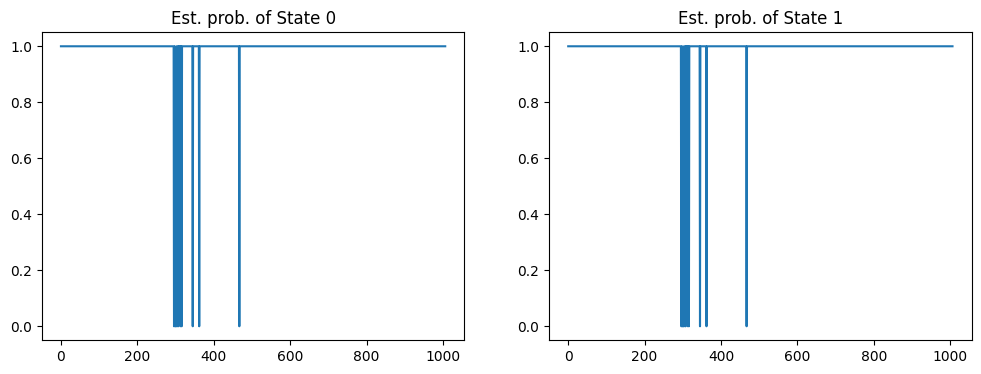


Diff.	: 0.9997051564187329
Iter.	: 0
Log-L	:  -29484.3591
Change	: 0.9997



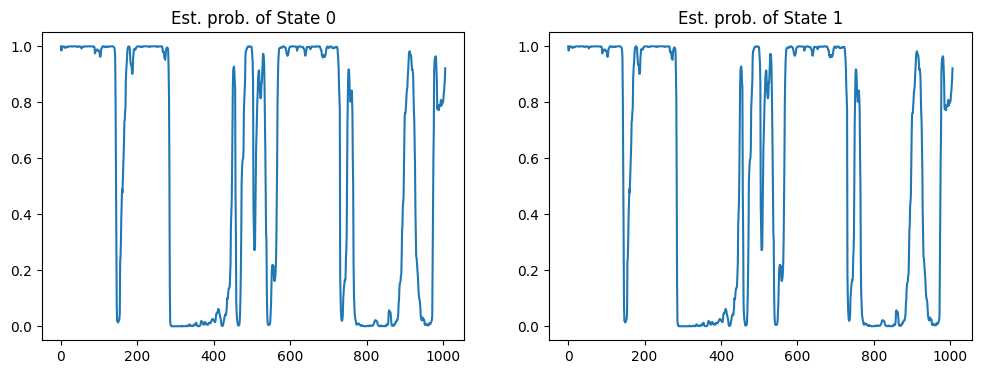


Diff.	: 0.0013741367086302205
Iter.	: 20
Log-L	:  -884.4723
Change	: 0.0014


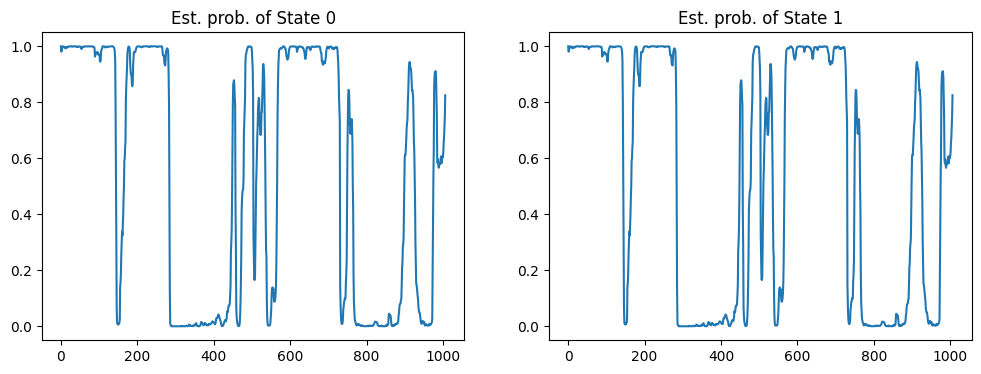


Diff.	: 8.315963521485356e-05
Iter.	: 23
Log-L	:  -883.8028
Change	: 0.0001

Final estimates
Log-L	: -883.8028
Akaike	: 1787.6056
Schward	: 1836.7529
Mu	:  [-0.7479 -0.1344]
Sigma	:  [0.5489 0.5692]
Trans mat 
[0.9823 0.0177]
[0.0212 0.9788]
Init P.	:  [1. 0.]


In [ ]:
# States 2

T = len(YData)
N = 2

# SET INITIAL GUESSES
mu_hat0 = [0, 2] * np.ones((N))
sigma_hat0 = [0.1, 0.1] * np.ones((N))
P_hat0 = np.zeros((N, N))

P_hat0[0, 0] = 0.75
P_hat0[0, 1] = 1 - P_hat0[0, 0]
P_hat0[1, 1] = 0.7
P_hat0[1, 0] = 1 - P_hat0[1, 1]

# Set as initial probability the stationary distribution
pi_hat0 = [0.5, 0.5] * np.ones((N))
for t in range(1, 100):
    pi_hat0 = np.dot(P_hat0.T, pi_hat0)


# Determine maximum number of iterations untill convergence and convergence tolerance
calibrate(N, T, mu_hat0, sigma_hat0, P_hat0, pi_hat0, YData)

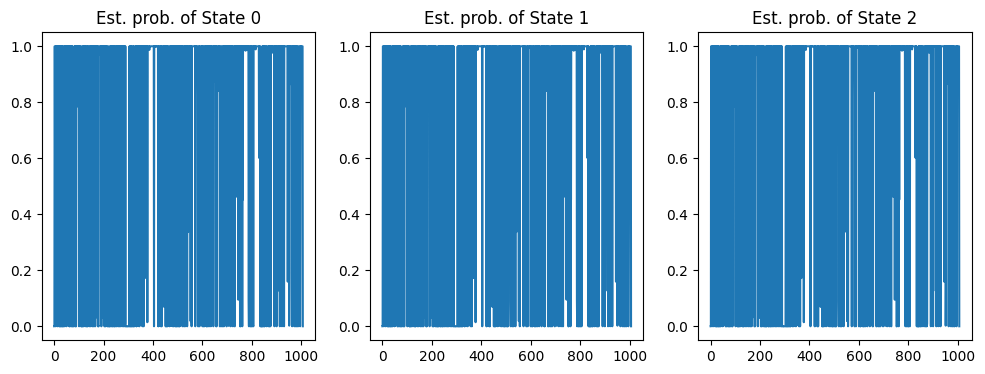


Diff.	: 0.9997628001143674
Iter.	: 0
Log-L	:  -23719.9896
Change	: 0.9998



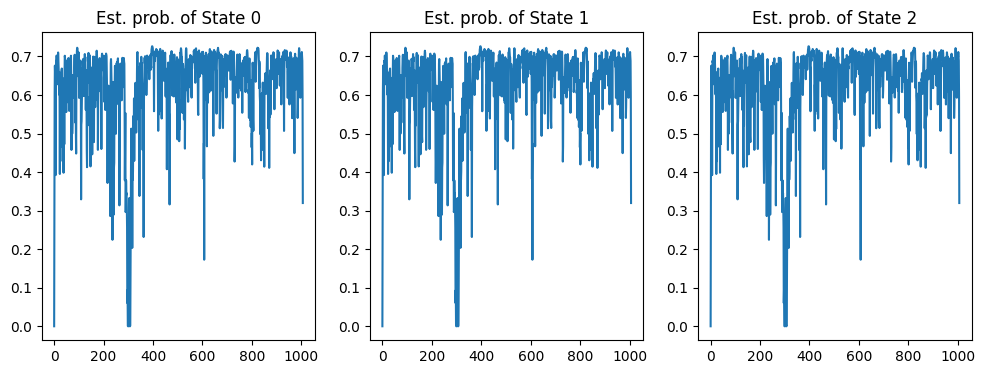


Diff.	: 0.000186453652570242
Iter.	: 20
Log-L	:  -951.6519
Change	: 0.0002



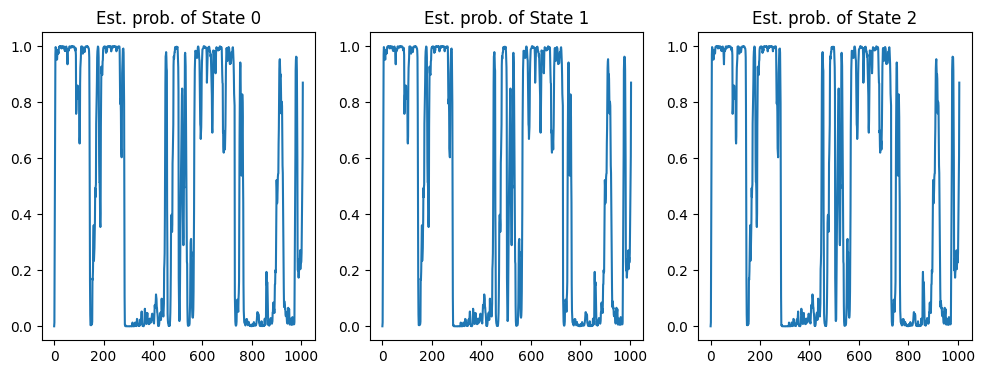


Diff.	: 0.0026898999118215895
Iter.	: 40
Log-L	:  -865.1132
Change	: 0.0027


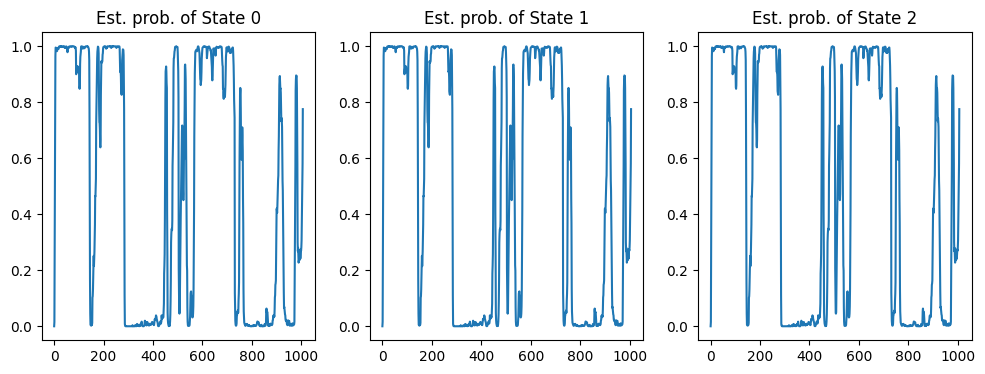


Diff.	: 7.736871685840876e-05
Iter.	: 45
Log-L	:  -862.6592
Change	: 0.0001

Final estimates
Log-L	: -862.6592
Akaike	: 1761.3185
Schward	: 1849.7836
Mu	:  [-0.7825  1.7004 -0.1688]
Sigma	:  [0.5359 0.0978 0.538 ]
Trans mat 
[0.9756 0.     0.0244]
[0.     0.5819 0.4181]
[0.0271 0.0044 0.9685]
Init P.	:  [0. 0. 1.]


In [ ]:
N = 3

# SET INITIAL GUESSES
mu_hat0 = [0, 2, 1] * np.ones((N))
sigma_hat0 = [0.1, 0.1, 0.2] * np.ones((N))
P_hat0 = np.zeros((N, N))

P_hat0 = np.random.randint(20, 100, (N, N))
P_hat0 = np.transpose(P_hat0/P_hat0.sum(axis=0))

pi_hat0 = np.random.randint(20, 100, N)
pi_hat0 = pi_hat0/pi_hat0.sum()

# Set as initial probability the stationary distribution
for t in range(1, 100):
    pi_hat0 = np.dot(P_hat0.T, pi_hat0)


# Determine maximum number of iterations untill convergence and convergence tolerance
calibrate(N, T, mu_hat0, sigma_hat0, P_hat0, pi_hat0, YData)

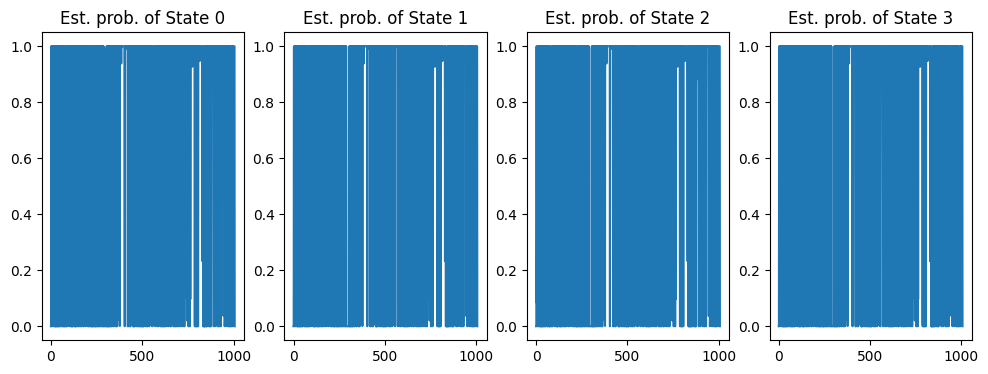


Diff.	: 0.9997705246795588
Iter.	: 0
Log-L	:  -22947.533
Change	: 0.9998



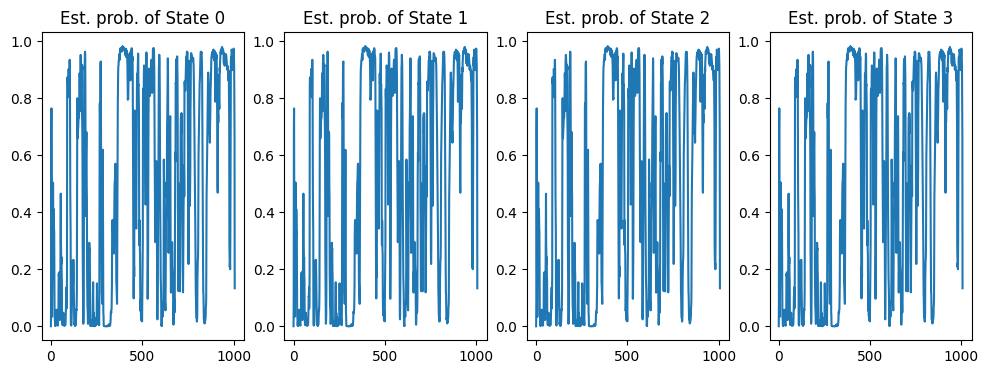


Diff.	: 0.0023392490735528607
Iter.	: 20
Log-L	:  -842.3852
Change	: 0.0023


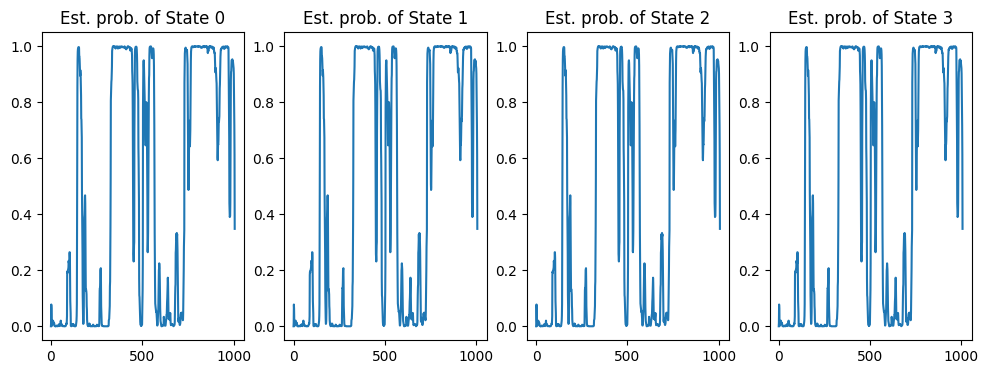


Diff.	: 9.959090557748012e-05
Iter.	: 38
Log-L	:  -828.9987
Change	: 0.0001

Final estimates
Log-L	: -828.9987
Akaike	: 1713.9974
Schward	: 1851.6098
Mu	:  [-0.2585  1.7044  0.4849 -0.8105]
Sigma	:  [0.5101 0.0959 0.5377 0.5316]
Trans mat 
[0.9786 0.     0.     0.0214]
[0.     0.5769 0.4231 0.    ]
[0.0295 0.0516 0.894  0.0249]
[0.0217 0.     0.0026 0.9758]
Init P.	:  [0. 0. 1. 0.]


In [ ]:
N = 4

# SET INITIAL GUESSES
mu_hat0 = [0, 2, 1, 2] * np.ones((N))
sigma_hat0 = [0.1, 0.1, 0.2, 0.3] * np.ones((N))
P_hat0 = np.zeros((N, N))

P_hat0 = np.random.randint(20, 100, (N, N))
P_hat0 = np.transpose(P_hat0/P_hat0.sum(axis=0))

pi_hat0 = np.random.randint(20, 100, N)
pi_hat0 = pi_hat0/pi_hat0.sum()

# Set as initial probability the stationary distribution
for t in range(1, 100):
    pi_hat0 = np.dot(P_hat0.T, pi_hat0)

# Determine maximum number of iterations untill convergence and convergence tolerance

calibrate(N, T, mu_hat0, sigma_hat0, P_hat0, pi_hat0, YData)

In [ ]:
def M_step_func(xi_prob, P, N, T, Y):
    mu_hat = np.zeros((N))
    sigma_hat = 0
    P_hat = np.zeros((N, N))
    pi_hat = np.zeros((N))

    for ss in range(0, N):
        xi_y = np.dot(xi_prob[:, ss], Y)
        mu_hat[ss] = xi_y / np.sum(xi_prob[:, ss])

        xi_y_mu2 = np.dot(xi_prob[:, ss], (Y - mu_hat[ss]) ** 2)
        # sigma_hat[ss] = (xi_y_mu2 / np.sum(xi_prob[:, ss])) ** 0.5
        sigma_hat += xi_y_mu2

        for ss2 in range(0, N):
            P_hat[ss, ss2] = np.sum(P[ss, ss2, 1:]) / np.sum(
                P[ss, :, 1:]
            )  # /np.sum(xi_prob[0:T-1,ss]) #np.sum(P[ss,:,1:T])
            # print( np.sum(xi_prob[0:T-1,ss]), np.sum(P[ss,:,1:T]))

        pi_hat[ss] = xi_prob[0, ss]
    sigma_hat = np.sqrt(sigma_hat/T)

    return mu_hat, sigma_hat, P_hat, pi_hat

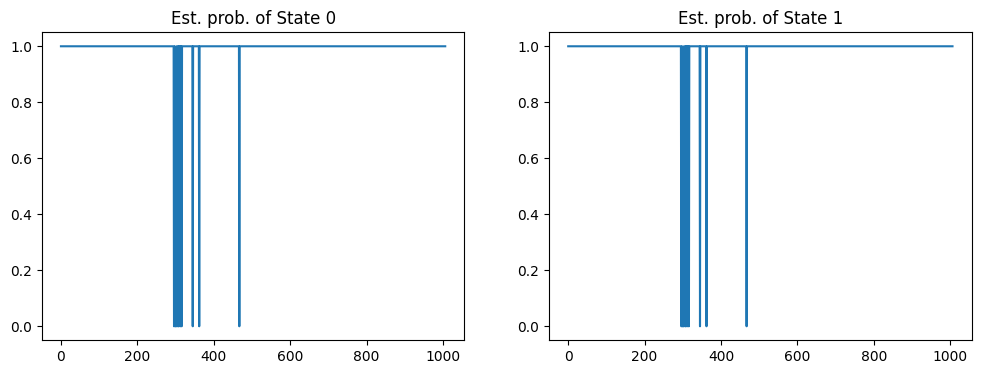


Diff.	: 0.9996973050654746
Iter.	: 0
Log-L	:  -30269.4945
Change	: 0.9997



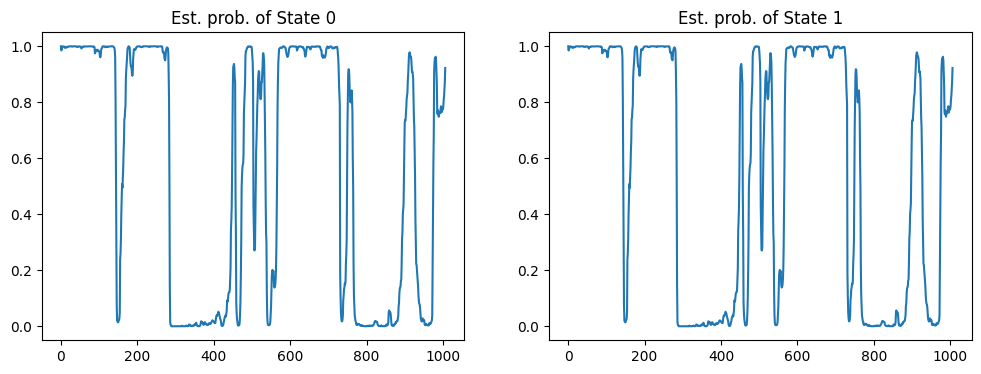


Diff.	: 0.000817277815272566
Iter.	: 20
Log-L	:  -884.4913
Change	: 0.0008


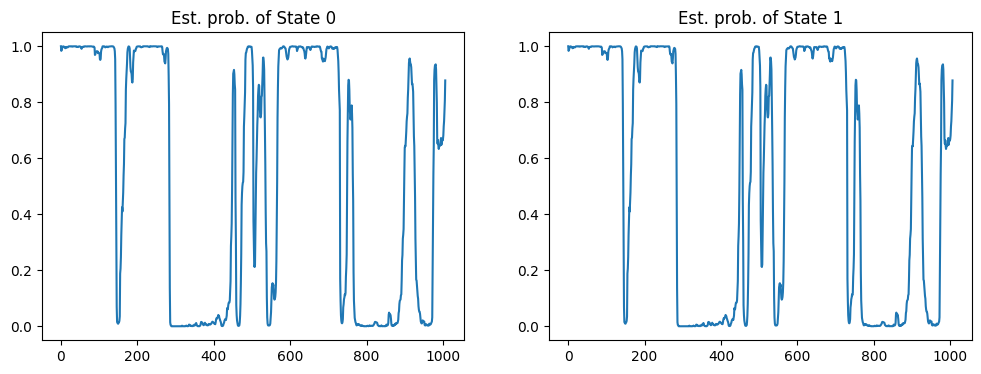


Diff.	: 9.589878077873847e-05
Iter.	: 22
Log-L	:  -884.1692
Change	: 0.0001

Final estimates
Log-L	: -884.1692
Akaike	: 1786.3385
Schward	: 1830.5711
Mu	:  [-0.7436 -0.1286]
Sigma	:  0.558
Trans mat 
[0.9826 0.0174]
[0.0216 0.9784]
Init P.	:  [1. 0.]


In [ ]:
# Different mu, same variance, N = 2

T = len(YData)
N = 2

# SET INITIAL GUESSES
mu_hat0 = [0, 2] * np.ones((N))
sigma_hat0 = [0.1, 0.1] * np.ones((N))

P_hat0 = np.random.randint(20, 100, (N, N))
P_hat0 = np.transpose(P_hat0/P_hat0.sum(axis=0))

pi_hat0 = np.random.randint(20, 100, N)
pi_hat0 = pi_hat0/pi_hat0.sum()

for t in range(1, 100):
    pi_hat0 = np.dot(P_hat0.T, pi_hat0)


# Determine maximum number of iterations untill convergence and convergence tolerance
calibrate(N, T, mu_hat0, sigma_hat0, P_hat0, pi_hat0, YData, method=1)

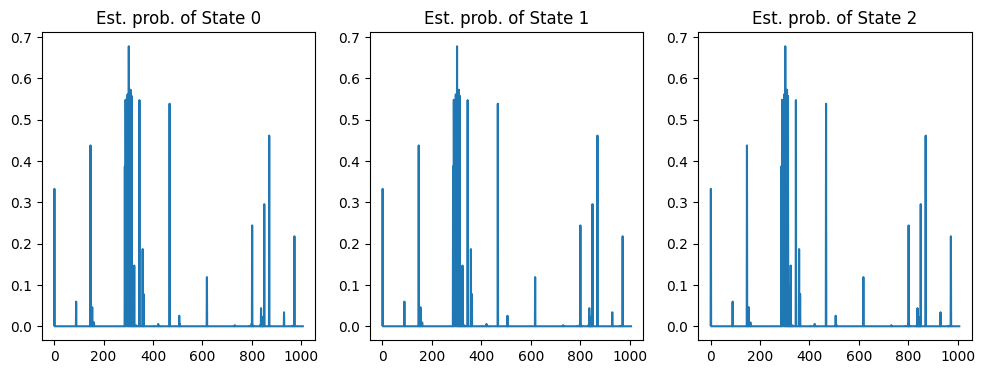


Diff.	: 0.9996740797018464
Iter.	: 0
Log-L	:  -32592.0308
Change	: 0.9997


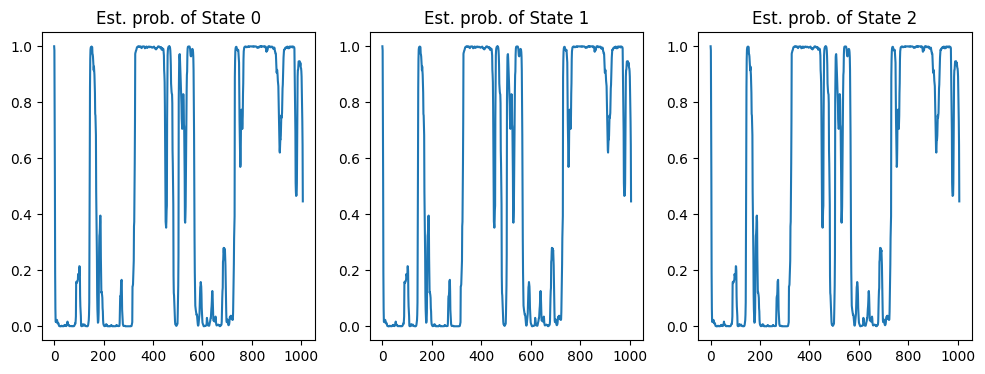


Diff.	: 7.972852005621015e-05
Iter.	: 19
Log-L	:  -837.9105
Change	: 0.0001

Final estimates
Log-L	: -837.9105
Akaike	: 1707.8211
Schward	: 1786.4568
Mu	:  [-0.2546 -0.8033  0.6611]
Sigma	:  0.5298
Trans mat 
[0.9797 0.0203 0.    ]
[0.0187 0.9791 0.0023]
[0.0269 0.     0.9731]
Init P.	:  [1. 0. 0.]


In [ ]:
# Different mu, same variance, N = 3

T = len(YData)
N = 3

# SET INITIAL GUESSES
mu_hat0 = [1, 1, 2] * np.ones((N))
sigma_hat0 = [0.1, 0.2, 0.1] * np.ones((N))

P_hat0 = np.random.randint(20, 100, (N, N))
P_hat0 = np.transpose(P_hat0/P_hat0.sum(axis=0))

pi_hat0 = np.random.randint(20, 100, N)
pi_hat0 = pi_hat0/pi_hat0.sum()

for t in range(1, 100):
    pi_hat0 = np.dot(P_hat0.T, pi_hat0)


# Determine maximum number of iterations untill convergence and convergence tolerance
calibrate(N, T, mu_hat0, sigma_hat0, P_hat0, pi_hat0, YData, method=1)

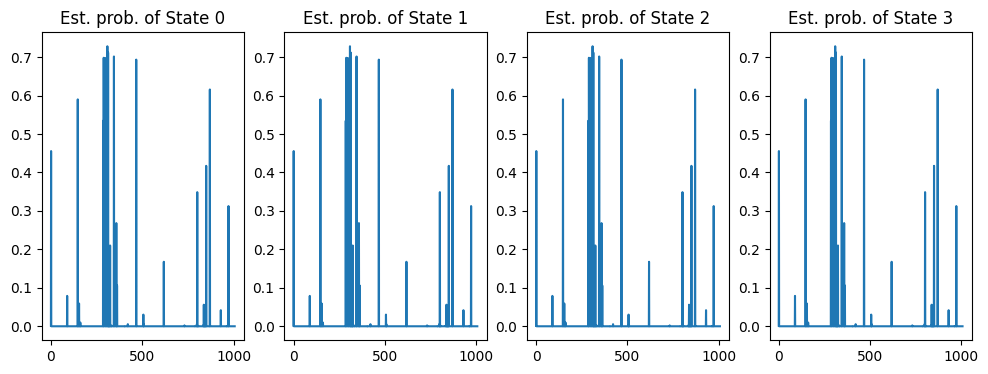


Diff.	: 0.9998442477902549
Iter.	: 0
Log-L	:  -15575.222
Change	: 0.9998


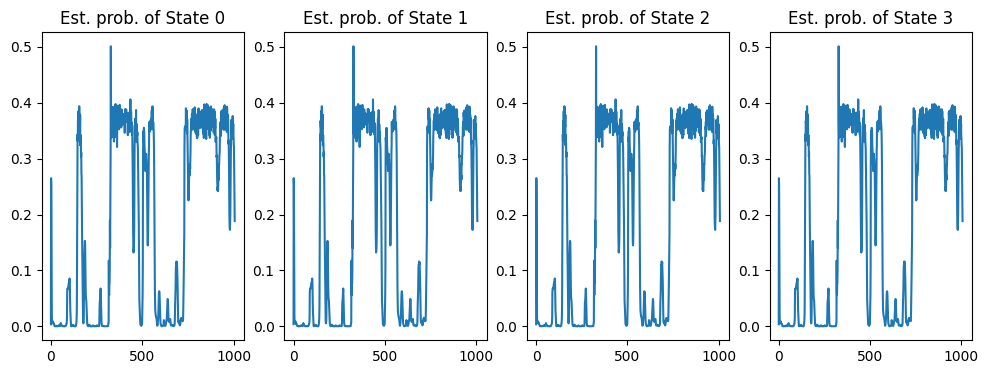


Diff.	: 7.448673087362783e-05
Iter.	: 18
Log-L	:  -837.9053
Change	: 0.0001

Final estimates
Log-L	: -837.9053
Akaike	: 1725.8106
Schward	: 1848.6789
Mu	:  [-0.2792 -0.2402  0.6617 -0.806 ]
Sigma	:  0.5289
Trans mat 
[0.4439 0.5406 0.     0.0155]
[0.3132 0.6624 0.     0.0244]
[0.0217 0.0052 0.9731 0.    ]
[0.0077 0.0121 0.0023 0.978 ]
Init P.	:  [0.0042 0.9958 0.     0.    ]


In [ ]:
# Different mu, same variance, N = 4

T = len(YData)
N = 4

# SET INITIAL GUESSES
mu_hat0 = [1, 1, 2, 1] * np.ones((N))
sigma_hat0 = [0.1, 0.2, 0.1, 0.3] * np.ones((N))

P_hat0 = np.random.randint(20, 100, (N, N))
P_hat0 = np.transpose(P_hat0/P_hat0.sum(axis=0))

pi_hat0 = np.random.randint(20, 100, N)
pi_hat0 = pi_hat0/pi_hat0.sum()

for t in range(1, 100):
    pi_hat0 = np.dot(P_hat0.T, pi_hat0)


# Determine maximum number of iterations untill convergence and convergence tolerance
calibrate(N, T, mu_hat0, sigma_hat0, P_hat0, pi_hat0, YData, method=1)

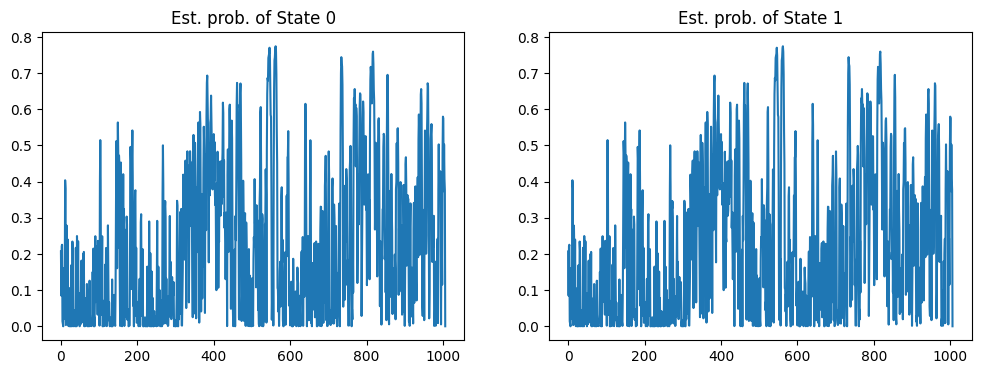


Diff.	: 0.9999832937024801
Iter.	: 0
Log-L	:  -1670.6308
Change	: 1.0



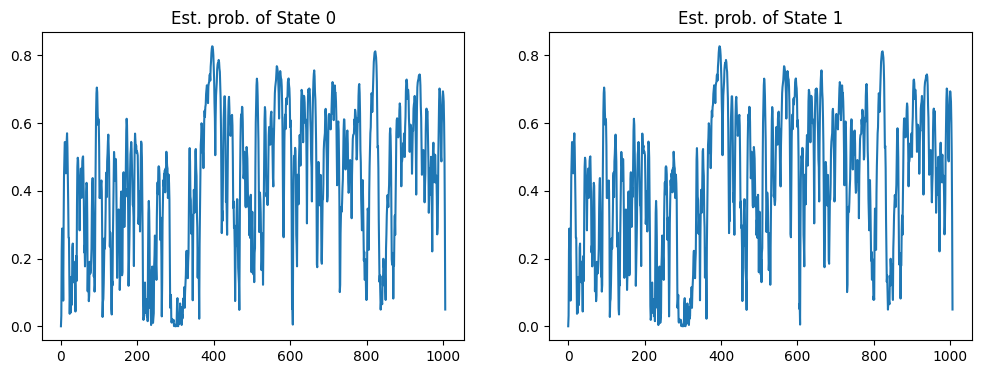


Diff.	: 0.000559396885373101
Iter.	: 20
Log-L	:  -963.6178
Change	: 0.0006



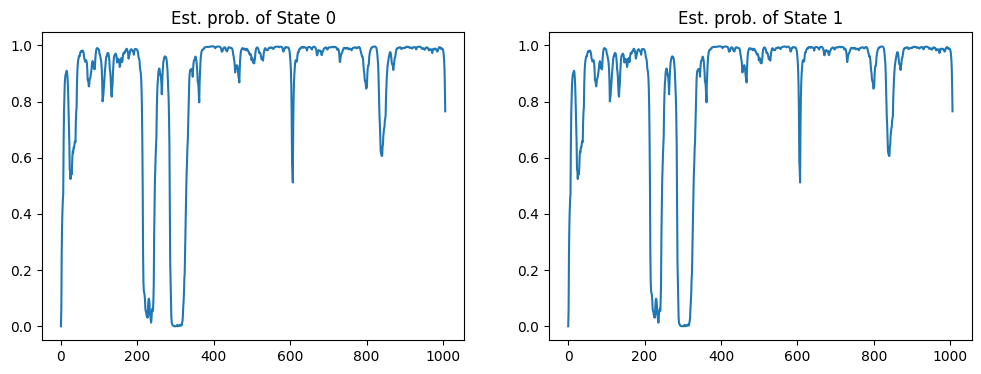


Diff.	: 0.001311711558597905
Iter.	: 40
Log-L	:  -943.462
Change	: 0.0013


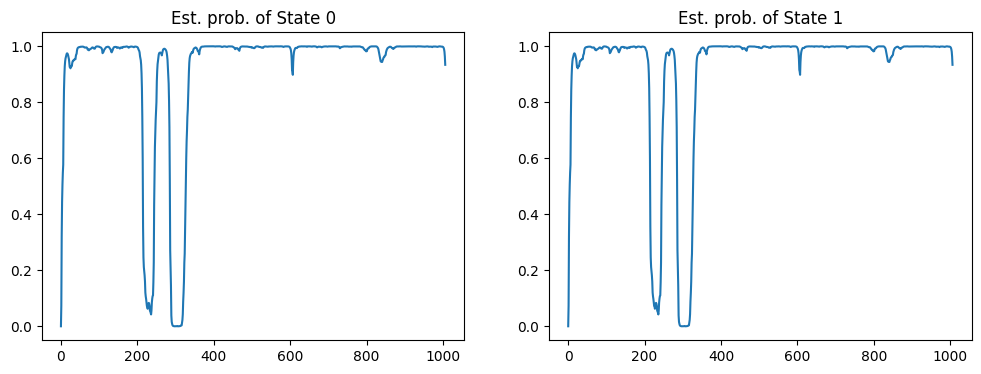


Diff.	: 4.524125204268694e-05
Iter.	: 46
Log-L	:  -940.3853
Change	: 0.0

Final estimates
Log-L	: -940.3853
Akaike	: 1898.7707
Schward	: 1943.0032
Mu	:  -0.4831
Sigma	:  [0.5752 1.1009]
Trans mat 
[0.9967 0.0033]
[0.0472 0.9528]
Init P.	:  [0. 1.]


In [ ]:
# same mu, different sigma N=2
T = len(YData)
N = 2

mu_hat0 = np.array([0, 0])
sigma_hat0 = np.array([0.3, 0.5] * np.ones(N))
P_hat0 = np.zeros((N, N))

P_hat0[0, 0] = 0.75
P_hat0[0, 1] = 1 - P_hat0[0, 0]
P_hat0[1, 1] = 0.7
P_hat0[1, 0] = 1 - P_hat0[1, 1]

# Set as initial probability the stationary distribution
pi_hat0 = [0.5, 0.5] * np.ones((N))
for t in range(1, 100):
    pi_hat0 = np.dot(P_hat0.T, pi_hat0)

calibrate(N, T, mu_hat0, sigma_hat0, P_hat0, pi_hat0, YData, method=2)

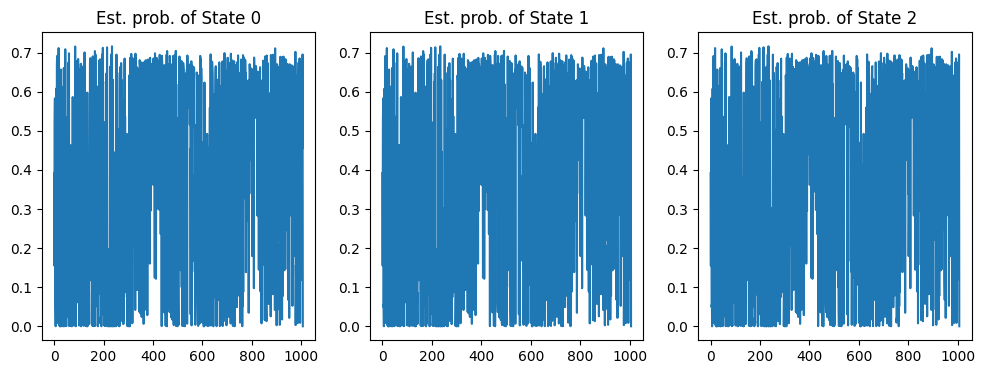


Diff.	: 0.99997773023085
Iter.	: 0
Log-L	:  -2226.9779
Change	: 1.0


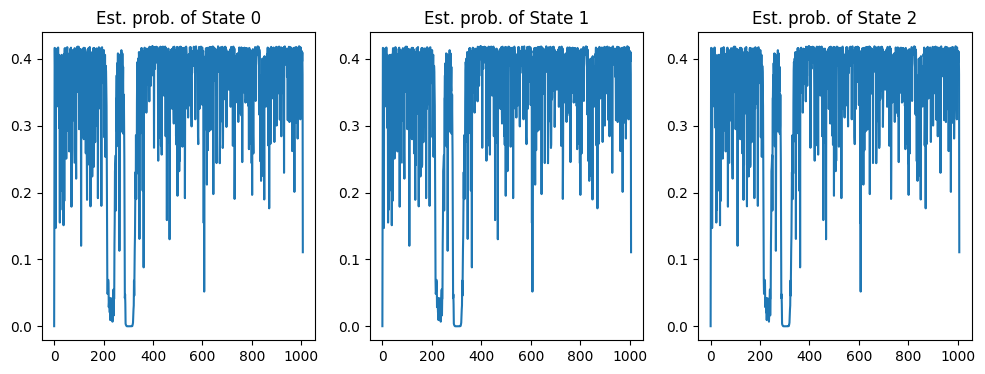


Diff.	: 9.515319061885809e-05
Iter.	: 10
Log-L	:  -940.7059
Change	: 0.0001

Final estimates
Log-L	: -940.7059
Akaike	: 1913.4117
Schward	: 1992.0474
Mu	:  -0.4834
Sigma	:  [0.506  0.6183 1.132 ]
Trans mat 
[0.3738 0.6253 0.0008]
[0.3659 0.6304 0.0036]
[0.0012 0.0312 0.9676]
Init P.	:  [2.000e-04 9.998e-01 0.000e+00]


In [ ]:
# same mu, different sigma N=3
T = len(YData)
N = 3

mu_hat0 = np.array([0, 0, 3])
sigma_hat0 = np.array([0.3, 0.5, 0.4] * np.ones(N))
P_hat0 = np.zeros((N, N))

P_hat0 = np.random.randint(20, 100, (N, N))
P_hat0 = np.transpose(P_hat0/P_hat0.sum(axis=0))

pi_hat0 = np.random.randint(20, 100, N)
pi_hat0 = pi_hat0/pi_hat0.sum()

# Set as initial probability the stationary distribution
for t in range(1, 100):
    pi_hat0 = np.dot(P_hat0.T, pi_hat0)

calibrate(N, T, mu_hat0, sigma_hat0, P_hat0, pi_hat0, YData, method=2)

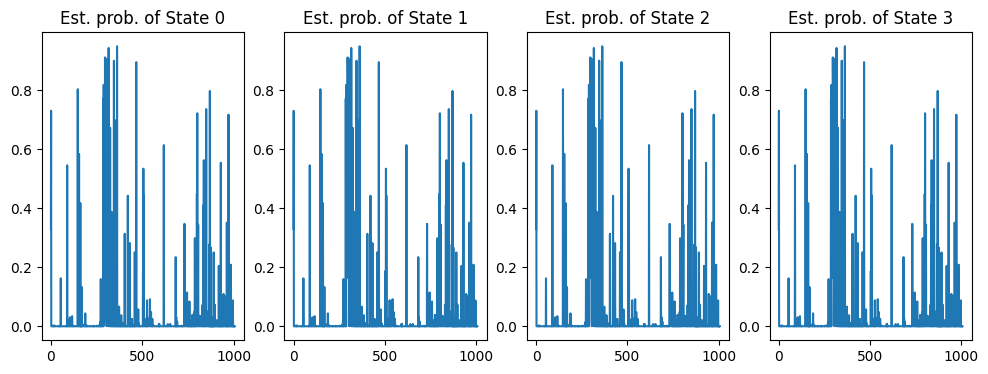


Diff.	: 0.9999784603342546
Iter.	: 0
Log-L	:  -2153.9676
Change	: 1.0


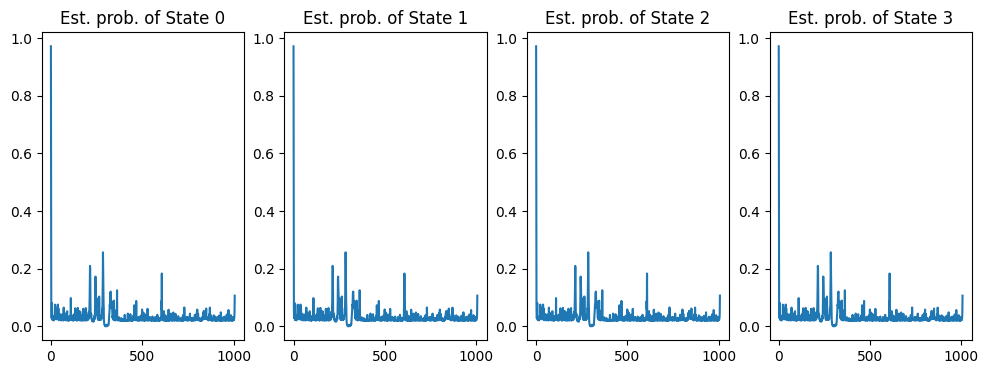


Diff.	: 9.210674315961668e-05
Iter.	: 8
Log-L	:  -940.117
Change	: 0.0001

Final estimates
Log-L	: -940.117
Akaike	: 1930.2341
Schward	: 2053.1023
Mu	:  -0.4847
Sigma	:  [0.7632 0.5964 0.4965 1.1529]
Trans mat 
[0.1874 0.5331 0.2058 0.0737]
[2.000e-02 8.202e-01 1.596e-01 2.000e-04]
[4.090e-02 5.013e-01 4.577e-01 1.000e-04]
[3.570e-02 5.000e-04 1.000e-04 9.636e-01]
Init P.	:  [0.9558 0.0441 0.     0.    ]


In [ ]:
# same mu, different sigma N=4
T = len(YData)
N = 4

mu_hat0 = np.array([1, 0, 0, 3])
sigma_hat0 = np.array([0.3, 0.5, 0.4, 0.5] * np.ones(N))
P_hat0 = np.zeros((N, N))

P_hat0 = np.random.randint(20, 100, (N, N))
P_hat0 = np.transpose(P_hat0/P_hat0.sum(axis=0))

pi_hat0 = np.random.randint(20, 100, N)
pi_hat0 = pi_hat0/pi_hat0.sum()

# Set as initial probability the stationary distribution
for t in range(1, 100):
    pi_hat0 = np.dot(P_hat0.T, pi_hat0)

calibrate(N, T, mu_hat0, sigma_hat0, P_hat0, pi_hat0, YData, method=2)

# **Step 4**

AR(1) process with variable coefficient $\rho = \rho(t)$.



In [ ]:
# Likelihood of an observation

def likelihood_AR1(xi_prob, mu, sigma, rho, y, y_1):

  phi = norm.pdf((y - mu - rho*y_1)/sigma)/sigma
  y_like = np.dot(xi_prob, phi)
  return y_like, phi

# Hamilton filtering
def forward_alg_AR1(pi0, N, T, P, mu, sigma, rho, Y):
    # Y : Time series
    xi_prob_t = np.zeros((T-1, N))
    xi_prob_t1 = np.zeros((T-1, N))

    # Case t=1
    # Likelihood of observation y_1 and marginal densities phi_1
    y_like, phi = likelihood_AR1(pi0, mu, sigma, rho, Y[1], Y[0])
    # xi_1|1
    xi_prob_t[0, :] = np.multiply(pi0, phi) / y_like
    # xi_{2}|1
    for ss in range(0, N):
        xi_prob_t1[0, ss] = np.dot(P[:, ss], xi_prob_t[0, :])
    # Case t > 1
    for tt in range(1, T-1):
        # Likelihood of observation y_t and marginal densities phi_t
        y_like, phi = likelihood_AR1(xi_prob_t1[tt - 1, :], mu, sigma, rho, Y[tt+1], Y[tt])
        # xi_t|t
        xi_prob_t[tt, :] = np.multiply(xi_prob_t1[tt - 1, :], phi) / y_like
        # xi_{t+1}|t
        for ss in range(0, N):
            xi_prob_t1[tt, ss] = np.dot(P[:, ss], xi_prob_t[tt, :])
    return xi_prob_t, xi_prob_t1


def M_step_func_AR1(xi_prob, P, N, T, Y):  #
    mu_hat = np.zeros((N))
    rho_hat = np.zeros((N))
    sigma_hat = np.zeros((N))
    P_hat = np.zeros((N, N))
    pi_hat = np.zeros((N))

    for ss in range(0, N):
        # We compute the new guess for the parameters mu and rho
        xi_y = np.sqrt(xi_prob[:, ss]) * Y[1:]
        z = np.stack((np.ones(T-1), Y[:-1]), axis=1)
        xi_z = np.zeros((T-1, N))
        xi_z[:, 0] = np.sqrt(xi_prob[:, ss]) * z[:, 0]
        xi_z[:, 1] = np.sqrt(xi_prob[:, ss]) * z[:, 1]
        z_xi_z_inv = np.linalg.inv(np.dot(xi_z.T, xi_z))
        beta_hat = np.dot(z_xi_z_inv, np.dot(xi_z.T, xi_y))

        mu_hat[ss] = beta_hat[0]
        rho_hat[ss] = beta_hat[1]

        residuals = Y[1:] - np.dot(z, beta_hat)
        xi_y_mu2 = np.dot(xi_prob[:, ss], residuals ** 2)
        sigma_hat[ss] = (xi_y_mu2 / np.sum(xi_prob[:, ss])) ** 0.5

        for ss2 in range(0, N):
          P_hat[ss, ss2] = np.sum(P[ss, ss2, 1:]) / np.sum(P[ss, :, 1:])
        pi_hat[ss] = xi_prob[0, ss]
    return mu_hat, rho_hat, sigma_hat, P_hat, pi_hat


def log_likelihood_AR1(xi_prob, T, pi_hat0, P, mu, sigma, rho, Y):
    y_like = np.zeros(T-1)
    for tt in range(0, T-1):
        y_like[tt], _ = likelihood_AR1(xi_prob[tt, :], mu, sigma, rho, Y[tt+1], Y[tt])
    sum_log_like = np.sum(np.log(y_like))
    k = (np.prod(mu.shape) + np.prod(sigma.shape) + np.prod(rho.shape))
    k += (np.prod(pi_hat0.shape) + np.prod(P.shape))
    n = len(Y)-1
    akaike = 2 * k - 2 * sum_log_like
    schwarz = k * np.log(n) - 2 * sum_log_like
    return sum_log_like, akaike, schwarz

In [ ]:
def calibrate_ar1(N, T, mu_hat0, sigma_hat0, P_hat0, rho_hat0, pi_hat0, df):
  # Determine maximum number of iterations until convergence and convergencve tolerance
  itemax = 200
  itetol = 1e-4
  log_like0 = -1e8

  for ite in range(0, itemax):
    # E-step
    xi_prob_t, xi_prob_t1 = forward_alg_AR1(pi_hat0, N, T, P_hat0, mu_hat0, sigma_hat0, rho_hat0, df)
    xi_prob_T = backward_alg(xi_prob_t, xi_prob_t1, N, T-1, P_hat0)

    #Compute Pr(s-t+1 = j, s_t = i)
    P_hat_T = np.zeros((N, N, T - 1))
    for tt in range(1, T-1):
      for ss in range(0, N):
        for ss2 in range(0, N):
          P_hat_T[ss, ss2, tt] = (P_hat0[ss, ss2] * xi_prob_t[tt - 1, ss] * xi_prob_T[tt, ss2] / xi_prob_t1[tt - 1, ss2])

    # NEW ## Instead of checking estimates we only check likelihood
    log_like1, akaike, schwarz = log_likelihood_AR1(np.concatenate(([pi_hat0], xi_prob_t1[0:T-2])),
                                                T, pi_hat0, P_hat0, mu_hat0, sigma_hat0, rho_hat0, df)
    diff = (log_like1 - log_like0)/abs(log_like0 + 1e-3)
    if ite%10 == 0 :
      print("")
      plt.subplot(1, 2, 1)
      plt.plot(xi_prob_T[:, 0])
      plt.title("Est. prob of state 0")
      plt.subplot(1, 2, 2)
      plt.plot(xi_prob_T[:, 1])
      plt.title("Est. prob of state 1")
      fig = plt.gcf()
      fig.set_size_inches(16, 4)
      plt.show()
      print("")
      print("Ite\t: ", ite)
      print("Log-L.\t: ", np.round(log_like1, 4))
      print("Change\t: ", np.round(diff, 4))

    # Stop when the difference in likelihood between steps is small
    if diff > itetol :
      # M-step
      mu_hat0, rho_hat0, sigma_hat0, P_hat0, pi_hat0 = M_step_func_AR1(xi_prob_T, P_hat_T, N, T, df)
      log_like0 = log_like1
    else:
      print("")
      plt.subplot(1, 2, 1)
      plt.plot(xi_prob_T[:, 0])
      plt.title("Est. prob of state 0")
      plt.subplot(1, 2, 2)
      plt.plot(xi_prob_T[:, 1])
      plt.title("Est. prob of state 1")
      fig = plt.gcf()
      fig.set_size_inches(16, 4)
      plt.show()
      print("")
      print("Ite\t:", ite)
      print("Log-L.\t:", np.round(log_like1, 4))
      print("Change\t:", np.round(diff, 4))

      print("Final estimates")
      print("==============================")
      print("Log-Likelihood: ", np.round(log_like1, 4), "Akaike: ",
            np.round(akaike, 4), "Schwarz: ", np.round(schwarz,4))
      print("Mu\t:", np.round(mu_hat0, 4))
      print("Sigma\t:", np.round(sigma_hat0, 4))
      print("Rho\t:", np.round(sigma_hat0, 4))
      print("Trans M\t:")
      for ss in range(N):
        print(np.round(P_hat0[ss, :],4))
      print("Init P.\t:", np.round(pi_hat0, 4))
      break

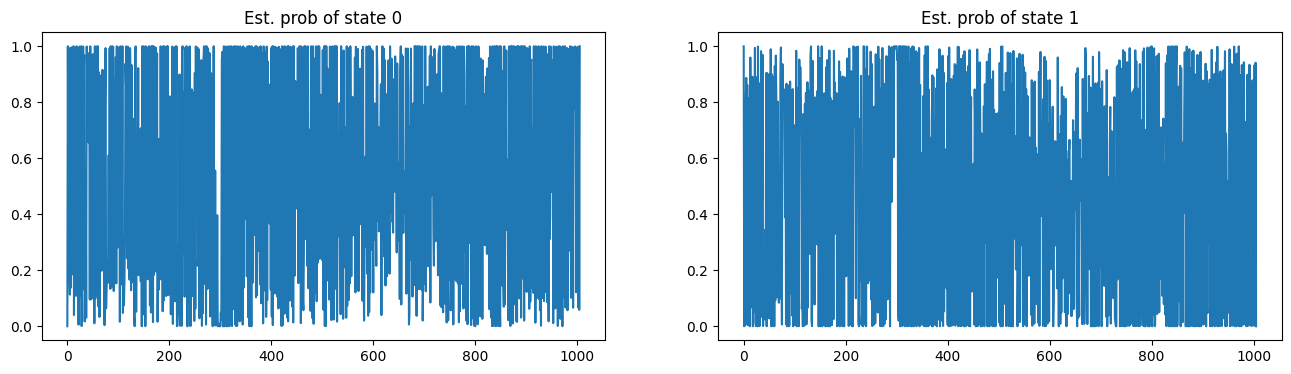


Ite	:  0
Log-L.	:  -20720.4094
Change	:  0.9998



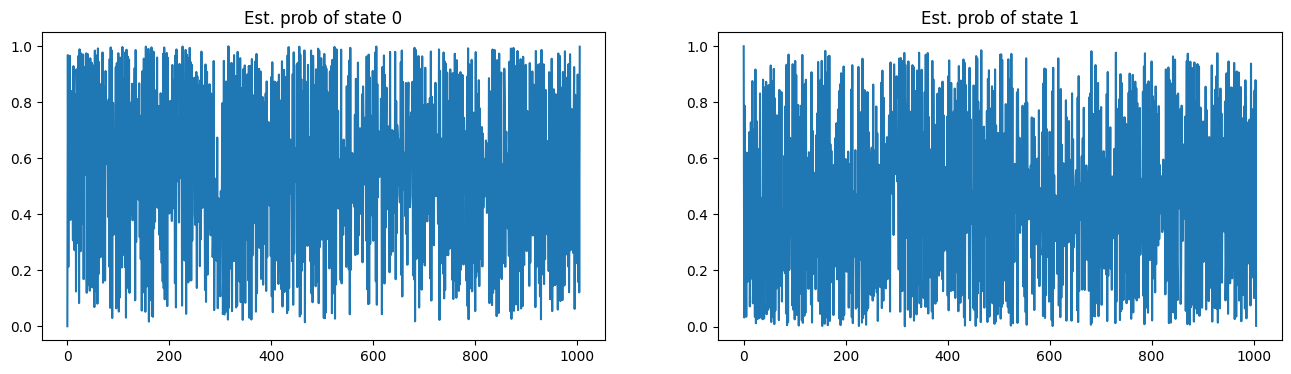


Ite	:  10
Log-L.	:  -905.9696
Change	:  0.0014



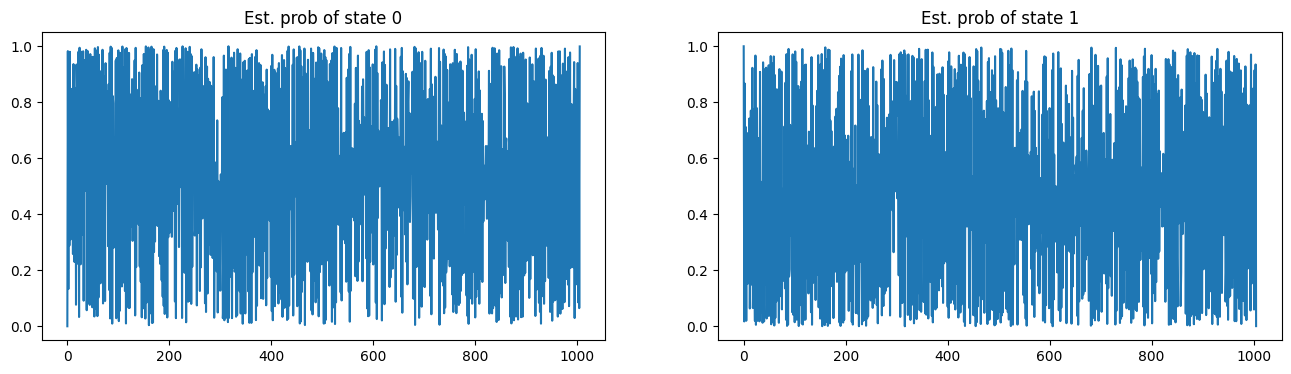


Ite	: 17
Log-L.	: -903.0685
Change	: 0.0001
Final estimates
Log-Likelihood:  -903.0685 Akaike:  1830.137 Schwarz:  1889.1018
Mu	: [-0.6012  0.1276]
Sigma	: [0.5119 0.4879]
Rho	: [0.5119 0.4879]
Trans M	:
[0.2781 0.7219]
[0.8364 0.1636]
Init P.	: [0. 1.]


In [ ]:
# Iniatial Parametes
T = len(YData)
N = 2

#SET Initial Guesses

mu_hat0 = [0, 0.1] * np.ones((N))
sigma_hat0 = [0.1, 0.1]*np.ones((N))
P_hat0 = np.zeros((N, N))

P_hat0 = np.random.randint(20, 100, (N, N))
P_hat0 = np.transpose(P_hat0/P_hat0.sum(axis=0))

pi_hat0 = np.random.randint(20, 100, N)
pi_hat0 = pi_hat0/pi_hat0.sum()

for t in range(1, 100):
  pi_hat0 = np.dot(P_hat0.T, pi_hat0)

# NEW : Initialize "rho"
rho_hat0 = [0.8, 0.5] * np.ones((N))

calibrate_ar1(N, T, mu_hat0, sigma_hat0, P_hat0, pi_hat0, rho_hat0, YData)

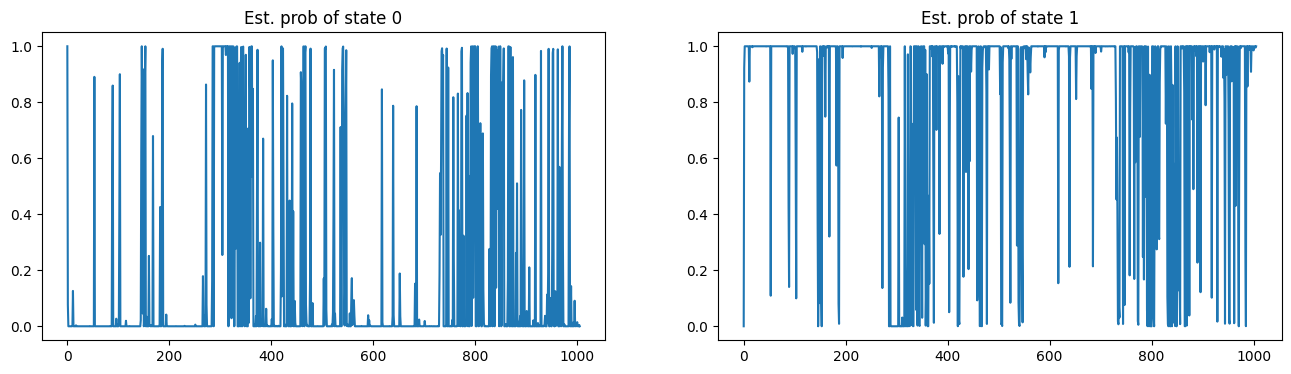


Ite	:  0
Log-L.	:  -56925.0109
Change	:  0.9994



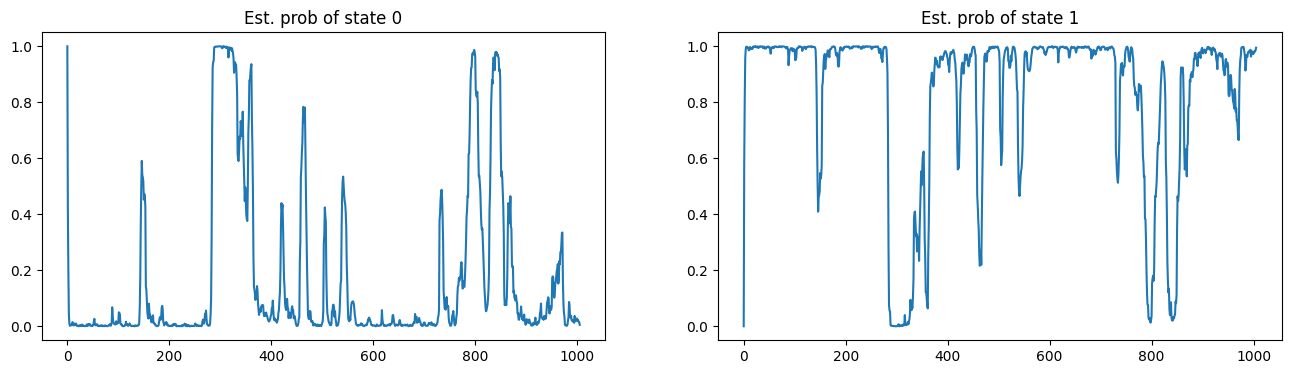


Ite	:  10
Log-L.	:  -891.1926
Change	:  0.0039



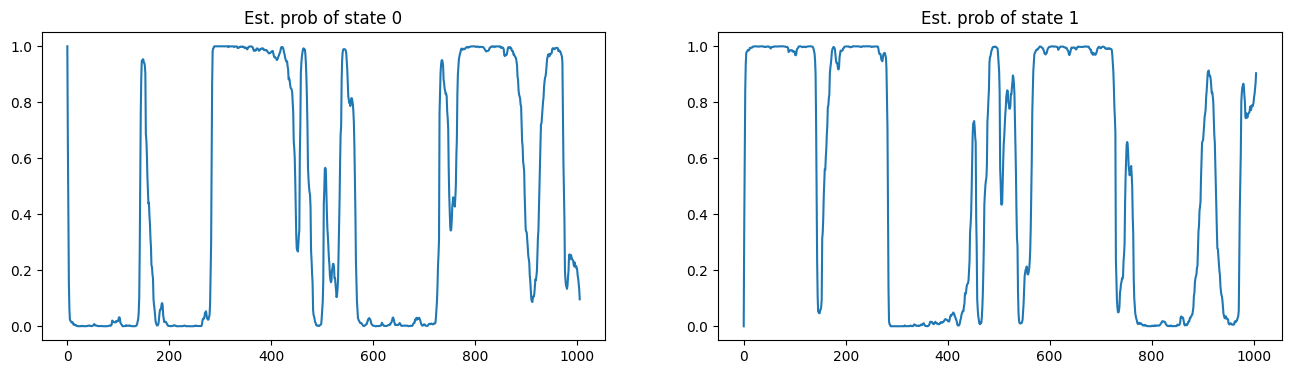


Ite	:  20
Log-L.	:  -875.4648
Change	:  0.0011



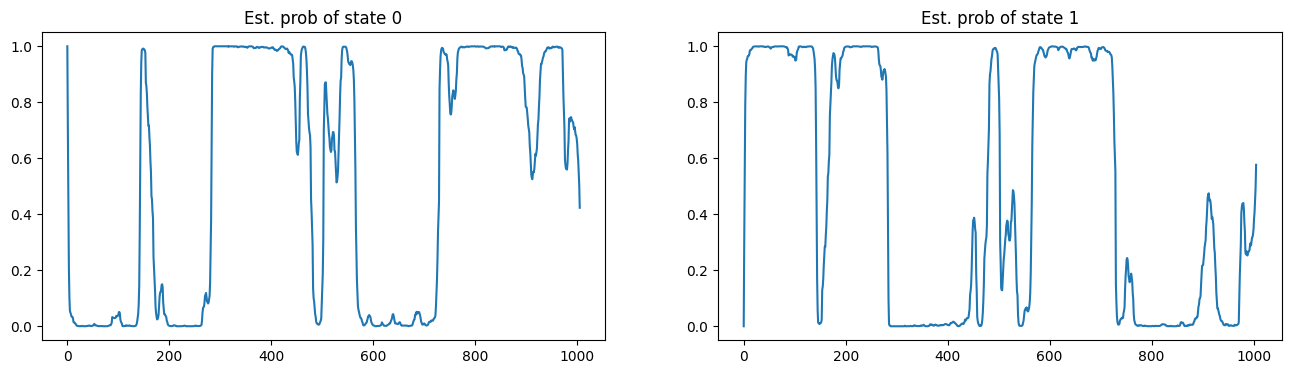


Ite	: 27
Log-L.	: -873.9353
Change	: 0.0001
Final estimates
Log-Likelihood:  -873.9353 Akaike:  1771.8705 Schwarz:  1830.8354
Mu	: [-0.1557 -0.731 ]
Sigma	: [0.5754 0.5409]
Rho	: [0.5754 0.5409]
Trans M	:
[0.9844 0.0156]
[0.0152 0.9848]
Init P.	: [1. 0.]


In [ ]:
#SET Initial Guesses
mu_hat0 = [2, 3] * np.ones((N))
sigma_hat0 = [0.2, 0.3]*np.ones((N))
P_hat0 = np.zeros((N, N))

P_hat0 = np.random.randint(20, 100, (N, N))
P_hat0 = np.transpose(P_hat0/P_hat0.sum(axis=0))

pi_hat0 = np.random.randint(20, 100, N)
pi_hat0 = pi_hat0/pi_hat0.sum()

for t in range(1, 100):
  pi_hat0 = np.dot(P_hat0.T, pi_hat0)

# NEW : Initialize "rho"
rho_hat0 = [0.3, 0.6] * np.ones((N))


calibrate_ar1(N, T, mu_hat0, sigma_hat0, P_hat0, pi_hat0, rho_hat0, YData)

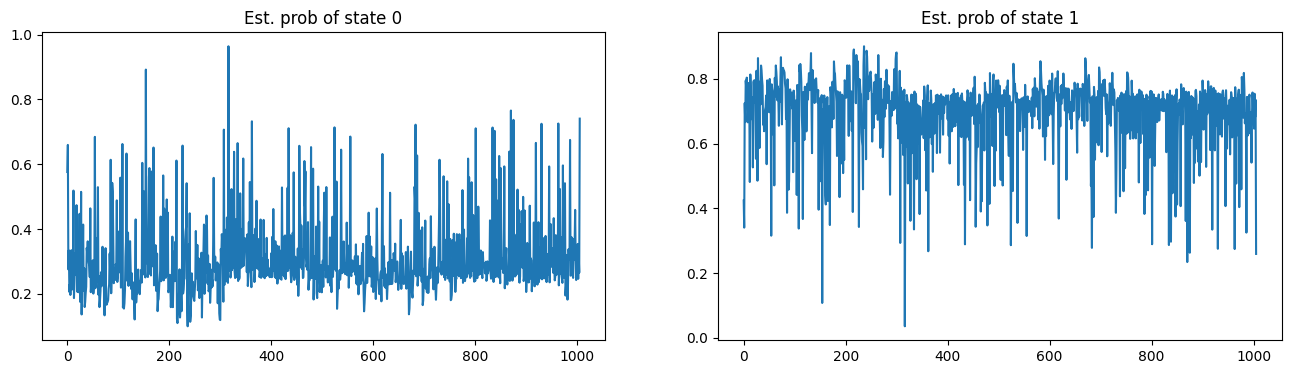


Ite	:  0
Log-L.	:  -1362.677
Change	:  1.0



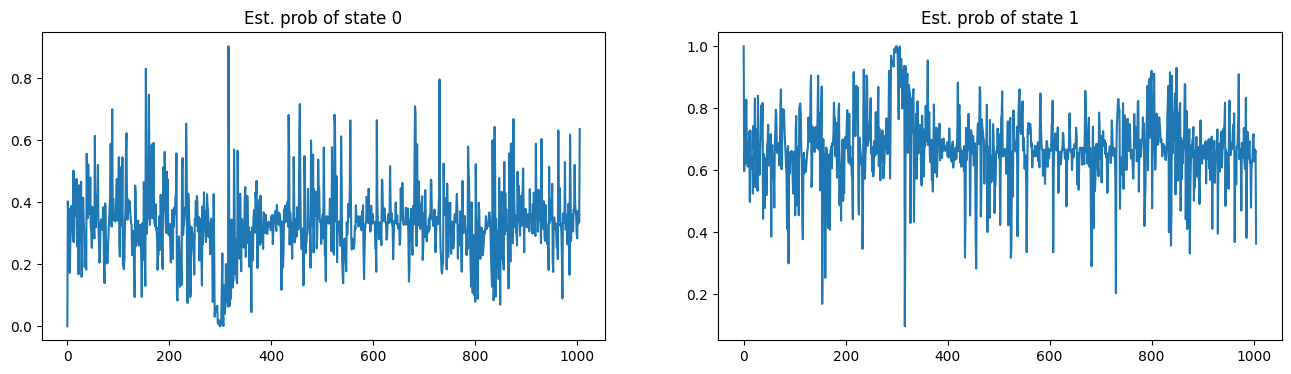


Ite	:  10
Log-L.	:  -919.5221
Change	:  0.0002



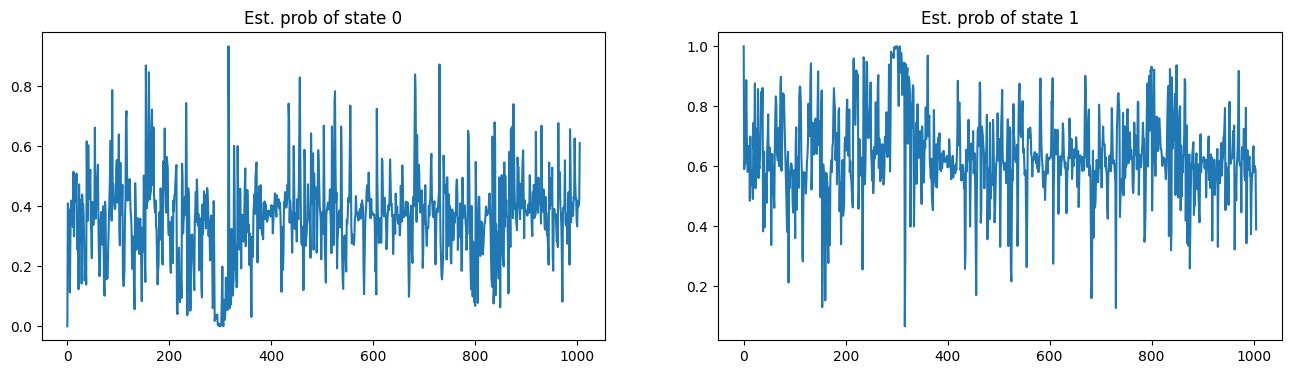


Ite	:  20
Log-L.	:  -917.4249
Change	:  0.0002



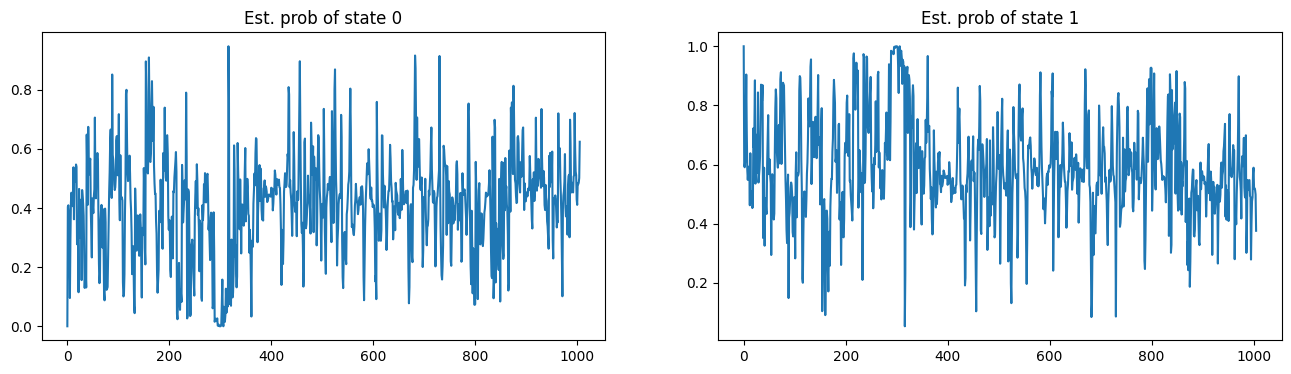


Ite	:  30
Log-L.	:  -915.073
Change	:  0.0003



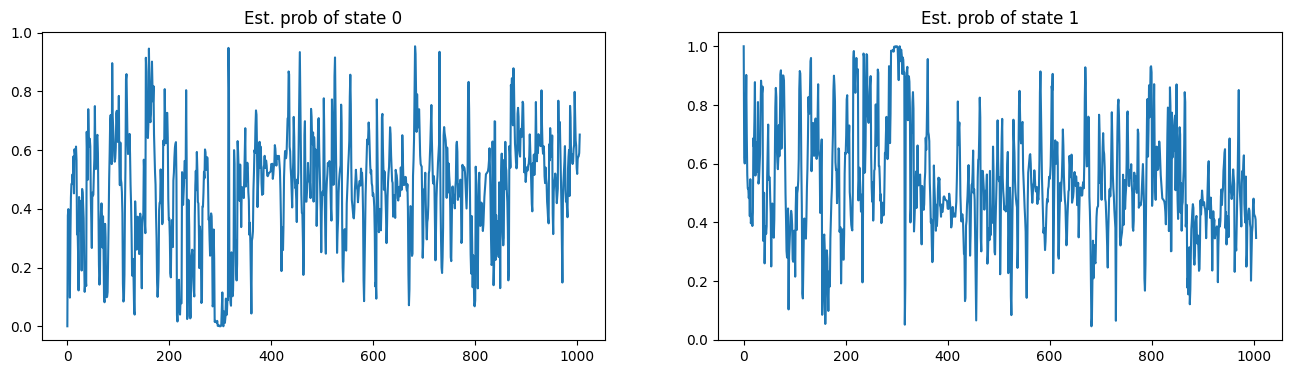


Ite	:  40
Log-L.	:  -912.5382
Change	:  0.0003



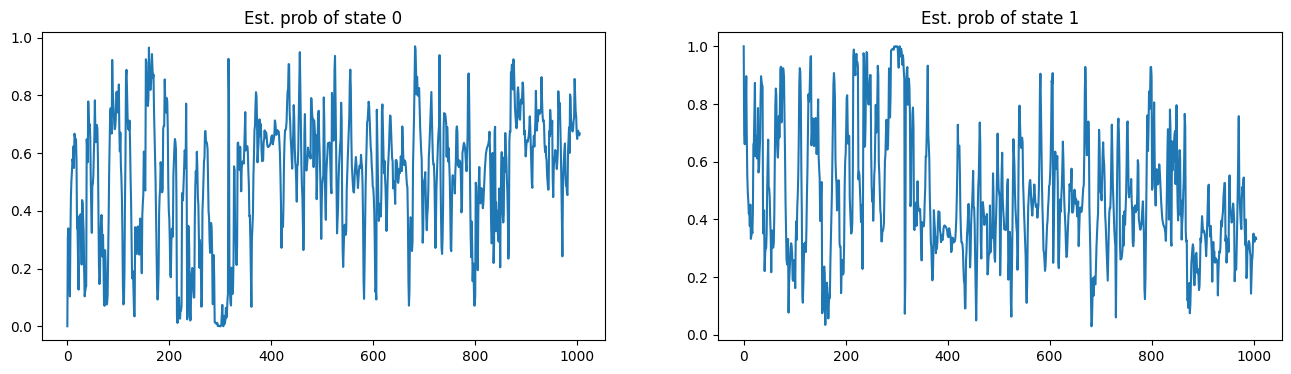


Ite	:  50
Log-L.	:  -909.8966
Change	:  0.0003



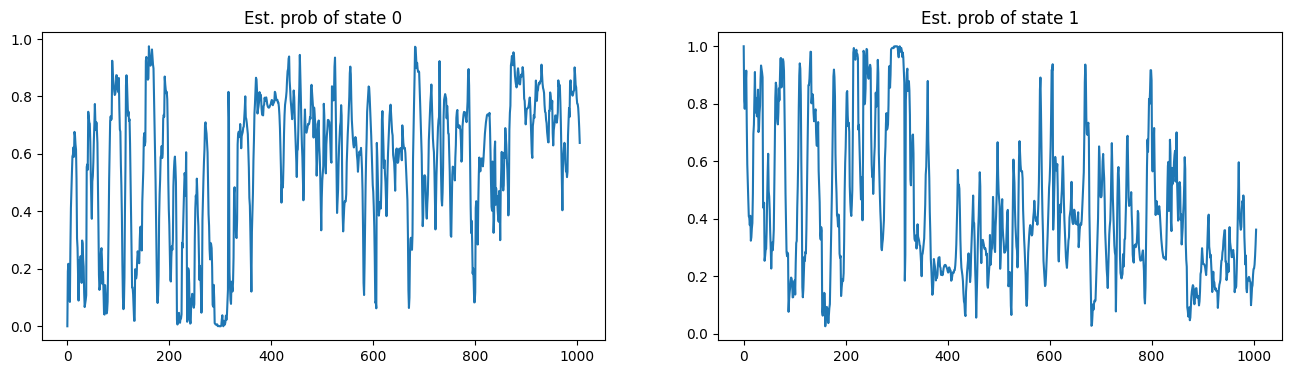


Ite	:  60
Log-L.	:  -906.8312
Change	:  0.0004



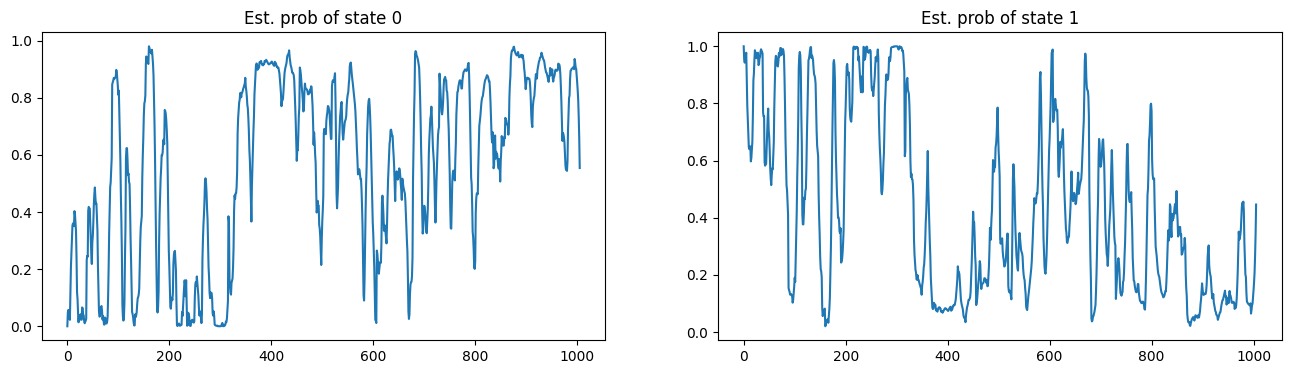


Ite	:  70
Log-L.	:  -901.1844
Change	:  0.001



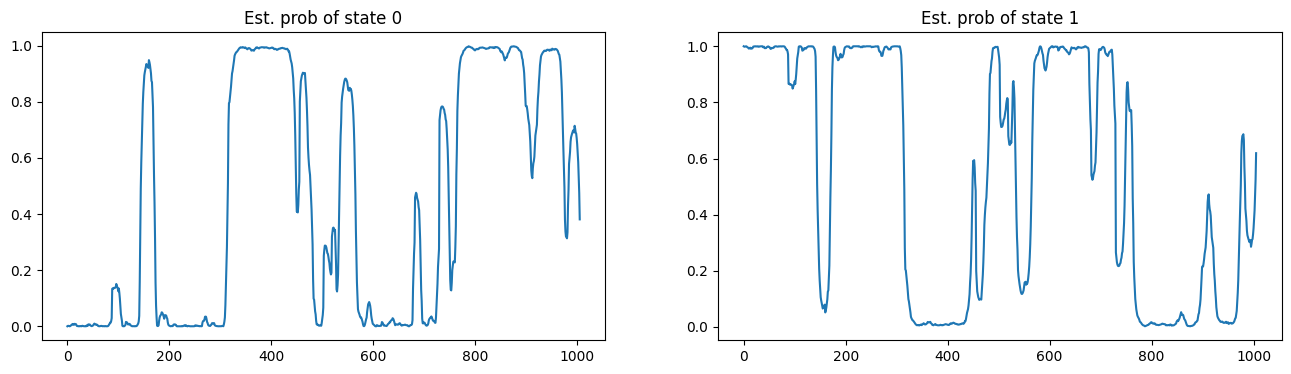


Ite	:  80
Log-L.	:  -886.662
Change	:  0.0002



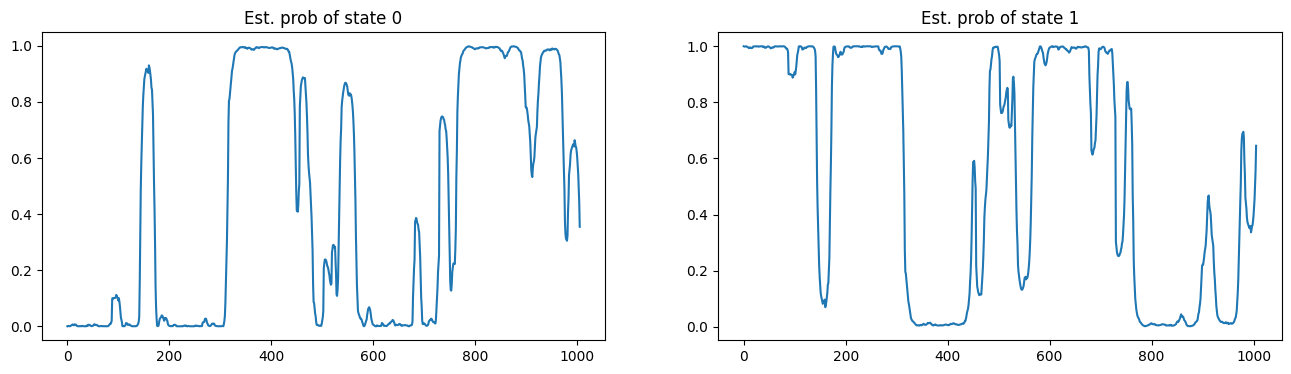


Ite	: 82
Log-L.	: -886.5299
Change	: 0.0
Final estimates
Log-Likelihood:  -886.5299 Akaike:  1797.0599 Schwarz:  1856.0247
Mu	: [-0.2579 -0.4197]
Sigma	: [0.5167 0.6118]
Rho	: [0.5167 0.6118]
Trans M	:
[0.9822 0.0178]
[0.0151 0.9849]
Init P.	: [0. 1.]


In [ ]:
# Iniatial Parametes
T = len(YData)
N = 2

#SET Initial Guesses

mu_hat0 = [0.3, 0.5] * np.ones((N))
sigma_hat0 = [0.8, 0.7]*np.ones((N))
P_hat0 = np.zeros((N, N))

P_hat0 = np.random.randint(20, 100, (N, N))
P_hat0 = np.transpose(P_hat0/P_hat0.sum(axis=0))

pi_hat0 = np.random.randint(20, 100, N)
pi_hat0 = pi_hat0/pi_hat0.sum()

for t in range(1, 100):
  pi_hat0 = np.dot(P_hat0.T, pi_hat0)

# NEW : Initialize "rho"
rho_hat0 = [0.8, 0.5] * np.ones((N))

calibrate_ar1(N, T, mu_hat0, sigma_hat0, P_hat0, pi_hat0, rho_hat0, YData)